In [1]:
    !pip install torch-geometric mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.0 MB/s eta 0:00:0000:01


In [2]:
# Import Standard Libraries (Available on Kaggle)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy import signal
import random
import time
import warnings
import math
from tqdm.notebook import tqdm
import mne
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("PyTorch version:", torch.__version__)
print("Device:", "CUDA" if torch.cuda.is_available() else "CPU")

PyTorch version: 2.6.0+cu124
Device: CPU


## 1. PhysioNet EEG Motor Movement/Imagery Dataset Loading

PhysioNet EEG Motor Movement/Imagery Dataset (EEGMIDB) for motor imagery classification:
- 64 EEG channels (10-10 international system)
- 160 Hz sampling rate  
- 1-second windows (160 samples)
- 4 classes: Left Fist, Right Fist, Both Fists, Both Feet
- Motor imagery runs: 4, 6, 8, 10, 12, 14 (excluding motor execution)

MNE version: 1.9.0
Loading EDF: /kaggle/input/eeg-motor-movementimagery-dataset/files/S001/S001R04.edf
Raw info summary:
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..'].

Consider using inst.rename_channel

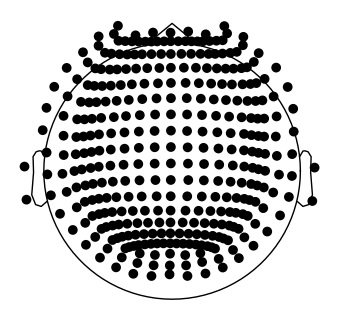

In [30]:
# STEP 1: environment check, locate EDF, load with MNE, show metadata, montage, and raw traces
import os
import glob
import sys
import numpy as np
import matplotlib.pyplot as plt

# ---------- Configuration ----------
DATA_DIR = '/kaggle/input/eeg-motor-movementimagery-dataset/files'  # update if needed
SUBJECT_ID = 1     # S001
RUN_NUMBER = 4     # imagery run (Task 2/4 depending on run)
MAX_CROP_SECS = 124.0
# -----------------------------------

# 1) Dependency check
try:
    import mne
    from mne.io import read_raw_edf
    from mne.channels import make_standard_montage
except Exception as e:
    print("MNE is not installed or import failed.")
    print("Please install MNE (recommended version 1.x):\n    pip install mne")
    raise

print(f"MNE version: {mne.__version__}")

# 2) Find the EDF file for the subject/run
subject_dir = os.path.join(DATA_DIR, f'S{SUBJECT_ID:03d}')
if not os.path.isdir(subject_dir):
    raise FileNotFoundError(f"Subject directory not found: {subject_dir}\n"
                            "Make sure DATA_DIR points to the dataset root containing S001, S002, ...")

# EDF pattern e.g. S001R04.edf
edf_pattern = os.path.join(subject_dir, f'S{SUBJECT_ID:03d}R{RUN_NUMBER:02d}.edf')
edf_files = glob.glob(edf_pattern)
if len(edf_files) == 0:
    raise FileNotFoundError(f"No EDF found matching {edf_pattern}. Available files:\n" +
                            "\n".join(glob.glob(os.path.join(subject_dir, "*.edf"))))

edf_path = edf_files[0]
print(f"Loading EDF: {edf_path}")

# 3) Load EDF with MNE (preload for in-memory ops)
raw = read_raw_edf(edf_path, preload=True, verbose=False)
print("Raw info summary:")
print(raw.info)

# Standardize montage and apply if possible
try:
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage, verbose=False)
    print("Montage set to 'standard_1005'.")
except Exception as e:
    print("Warning: could not set montage:", e)

# Crop to MAX_CROP_SECS to match dataset handling (if longer)
if raw.times[-1] > MAX_CROP_SECS:
    raw.crop(tmax=MAX_CROP_SECS)
    print(f"Cropped raw data to tmax={MAX_CROP_SECS} s.")

sfreq = raw.info['sfreq']
print(f"Sampling rate: {sfreq} Hz; channels: {len(raw.ch_names)}")

# 4) Extract annotations/events (EDF stores annotations)
annotations = raw.annotations
if annotations is None or len(annotations) == 0:
    print("WARNING: No annotations found in EDF annotations channel.")
else:
    print(f"Found {len(annotations)} annotations. First 10:")
    for a in annotations[:10]:
        print(f"  onset={a['onset']:.3f}s dur={a['duration']:.3f}s desc={a['description']}")

# Also convert to MNE events (numeric codes)
try:
    events, event_id = mne.events_from_annotations(raw)
    print(f"Converted annotations to {len(events)} MNE events. event_id mapping: {event_id}")
    # Print counts per event label
    unique, counts = np.unique(events[:, 2], return_counts=True)
    print("Event code counts (code:count):", dict(zip(unique.astype(int), counts)))
except Exception as e:
    print("Could not convert annotations to events:", e)
    events = np.empty((0, 3))

# 5) Plot montage and a small excerpt of raw traces (matplotlib)
# We'll plot the channel montage on left and a time-series excerpt on right
plot_channels = raw.ch_names[:5]  # first 5 channels for a compact trace view

# Choose time window to display:
# Prefer window around the first event onset if available, else start at 0
if events.shape[0] > 0:
    first_onset_sample = int(events[0, 0])
    first_onset_time = first_onset_sample / sfreq
    t0 = max(0.0, first_onset_time - 0.5)  # start 0.5s before event
    t1 = t0 + 5.0  # show 5 seconds (adjustable)
else:
    t0 = 0.0
    t1 = min(5.0, raw.times[-1])

print(f"Plotting time window from {t0:.3f}s to {t1:.3f}s for channels: {plot_channels}")

# Extract data for plotting
start_samp = int(t0 * sfreq)
stop_samp = int(t1 * sfreq)
data, times = raw.get_data(picks=plot_channels, start=start_samp, stop=stop_samp, return_times=True)

# Create figure
fig = plt.figure(figsize=(14, 5))

# Montage subplot (left)
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=1)
try:
    # Use MNE's plotting for positions if montage present (draw as simple scatter)
    pos = np.array([raw.info['chs'][raw.ch_names.index(ch)]['loc'][:3] for ch in raw.ch_names if 'EEG' in raw.get_channel_types(picks=[raw.ch_names.index(ch)])[0]])
    # Fallback: use mne.viz.plot_montage if available
    mne.viz.plot_montage(montage, show_names=False, axes=ax1, sphere=None)
    ax1.set_title('Channel locations (montage)')
except Exception:
    ax1.text(0.5, 0.5, 'Montage plotting not available', ha='center')
    ax1.set_title('Channel locations (not available)')


In [31]:
# ---------- PhysioNet 64-channel renaming for montage ----------
print("\n>>> Renaming PhysioNet channels to standard 10-10 names")

# Mapping PhysioNet raw names (with dots) to 10-10 standard names
physionet_to_standard = {
    'Fc5.': 'FC5',  'Fc3.': 'FC3',  'Fc1.': 'FC1',  'Fcz.': 'FCZ',  'Fc2.': 'FC2',  'Fc4.': 'FC4',  'Fc6.': 'FC6',
    'C5..': 'C5',   'C3..': 'C3',   'C1..': 'C1',   'Cz..': 'CZ',   'C2..': 'C2',   'C4..': 'C4',   'C6..': 'C6',
    'Cp5.': 'CP5',  'Cp3.': 'CP3',  'Cp1.': 'CP1',  'Cpz.': 'CPZ',  'Cp2.': 'CP2',  'Cp4.': 'CP4',  'Cp6.': 'CP6',
    'Fp1.': 'FP1',  'Fpz.': 'FPZ',  'Fp2.': 'FP2',  'Af7.': 'AF7',  'Af3.': 'AF3',  'Afz.': 'AFZ',  'Af4.': 'AF4',  'Af8.': 'AF8',
    'F7..': 'F7',   'F5..': 'F5',   'F3..': 'F3',   'F1..': 'F1',   'Fz..': 'FZ',   'F2..': 'F2',   'F4..': 'F4',   'F6..': 'F6',   'F8..': 'F8',
    'Ft7.': 'FT7',  'Ft8.': 'FT8',
    'T7..': 'T7',   'T8..': 'T8',   'T9..': 'T9',   'T10.': 'T10',
    'Tp7.': 'TP7',  'Tp8.': 'TP8',
    'P7..': 'P7',   'P5..': 'P5',   'P3..': 'P3',   'P1..': 'P1',   'Pz..': 'PZ',   'P2..': 'P2',   'P4..': 'P4',   'P6..': 'P6',   'P8..': 'P8',
    'Po7.': 'PO7',  'Po3.': 'PO3',  'Poz.': 'POZ',  'Po4.': 'PO4',  'Po8.': 'PO8',
    'O1..': 'O1',   'Oz..': 'OZ',   'O2..': 'O2',   'Iz..': 'IZ'
}

# Check which channels in raw match the mapping
raw_channels_in_map = [ch for ch in raw.ch_names if ch in physionet_to_standard]
missing = [ch for ch in raw.ch_names if ch not in physionet_to_standard]
print(f"Channels mapped: {len(raw_channels_in_map)}/{len(raw.ch_names)}")
if missing:
    print("Channels not in mapping (will remain unchanged):", missing)

# Apply renaming
raw.rename_channels(physionet_to_standard)



>>> Renaming PhysioNet channels to standard 10-10 names
Channels mapped: 64/64


<RawEDF | S001R04.edf, 64 x 19841 (124.0 s), ~9.7 MiB, data loaded>

Failed to set montage even after renaming: Invalid value for the 'kind' parameter. Allowed values are 'standard_1005', 'standard_1020', 'standard_alphabetic', 'standard_postfixed', 'standard_prefixed', 'standard_primed', 'biosemi16', 'biosemi32', 'biosemi64', 'biosemi128', 'biosemi160', 'biosemi256', 'easycap-M1', 'easycap-M10', 'easycap-M43', 'EGI_256', 'GSN-HydroCel-32', 'GSN-HydroCel-64_1.0', 'GSN-HydroCel-65_1.0', 'GSN-HydroCel-128', 'GSN-HydroCel-129', 'GSN-HydroCel-256', 'GSN-HydroCel-257', 'mgh60', 'mgh70', 'artinis-octamon', 'artinis-brite23', and 'brainproducts-RNP-BA-128', but got 'standard_1010' instead.
4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


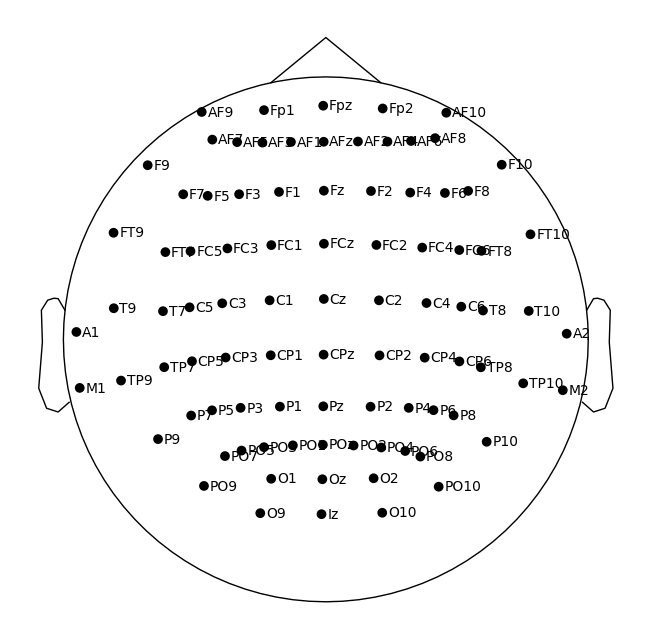

In [35]:

# Apply standard montage
try:
    montage = mne.channels.make_standard_montage('standard_1010')
    raw.set_montage(montage, match_case=False, verbose=False)
    print("Montage set successfully after renaming.")
except Exception as e:
    print("Failed to set montage even after renaming:", e)

# Optional: plot montage
try:
     
    mne.viz.plot_montage(montage, show_names=True,sphere=0.115)
except:
    print("Montage plotting failed.")


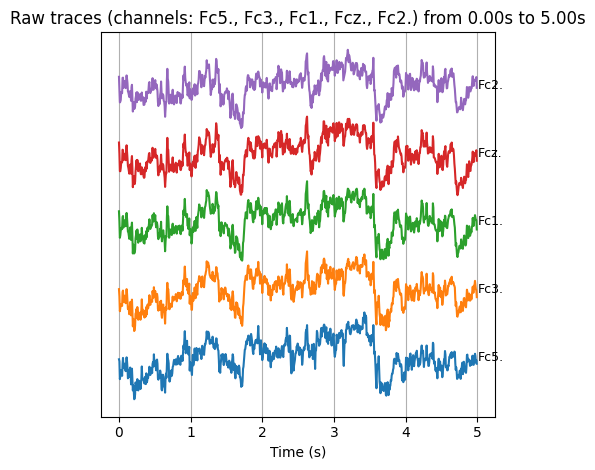


NEXT (recommended) steps you can run after verifying the above:
  1) Rereference (common average or linked-mastoids)
  2) Baseline correction (per epoch, if you extract epochs)
  3) Band-pass filter (1-35 Hz) and notch if needed
  4) Epoch extraction around events (4s epochs for imagery trials)
  5) Compute PLV for each epoch and visualize adjacency matrices / graphs

Run this block and confirm the plots/text above. When you say 'OK',
I'll provide the next code piece that performs rereferencing + baseline correction + visualization.


In [36]:

# Time-series subplot (right)
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
offset = 0.0
offset_step = np.max(np.abs(data)) * 1.5 if data.size else 1.0
for i, ch_name in enumerate(plot_channels):
    ch_trace = data[i, :]
    ax2.plot(times, ch_trace + offset, label=ch_name)
    ax2.text(times[-1] + 0.01, offset, ch_name, va='center', fontsize=9)
    offset += offset_step
ax2.set_xlabel('Time (s)')
ax2.set_yticks([])
ax2.set_title(f'Raw traces (channels: {", ".join(plot_channels)}) from {t0:.2f}s to {t1:.2f}s')
ax2.grid(True)
plt.tight_layout()
plt.show()




>>> STEP 2: Rereferencing + Baseline Correction
Common average reference applied.


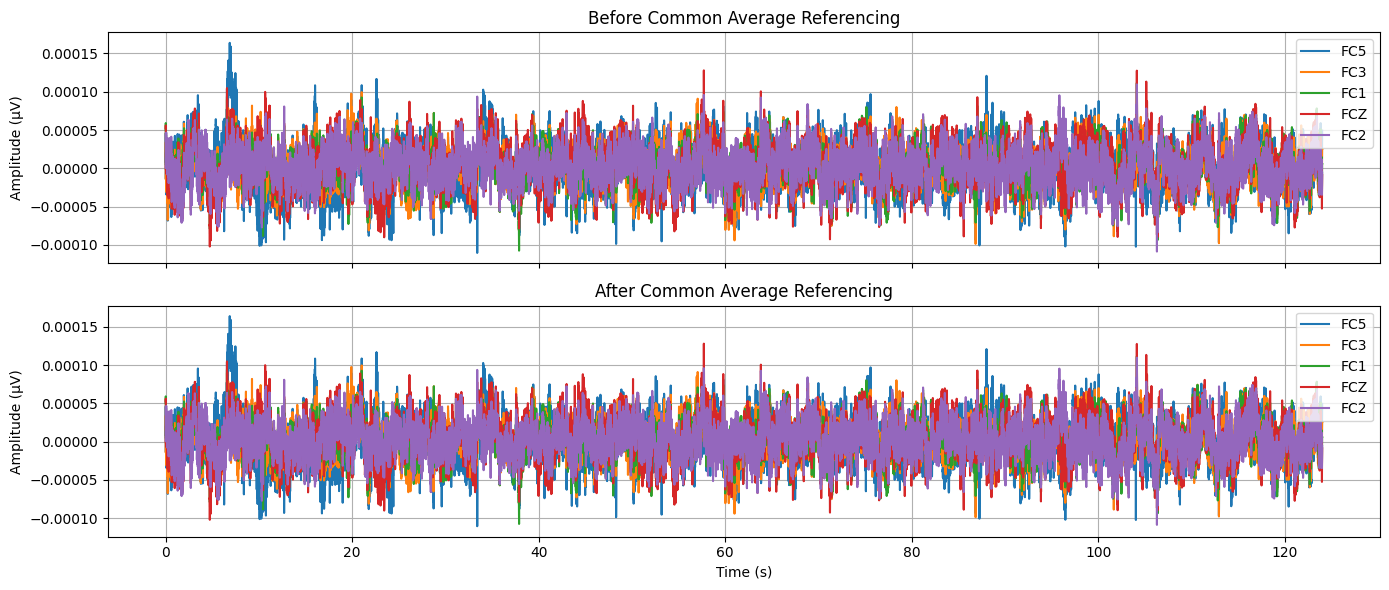

Extracted 21 epochs with baseline correction applied.


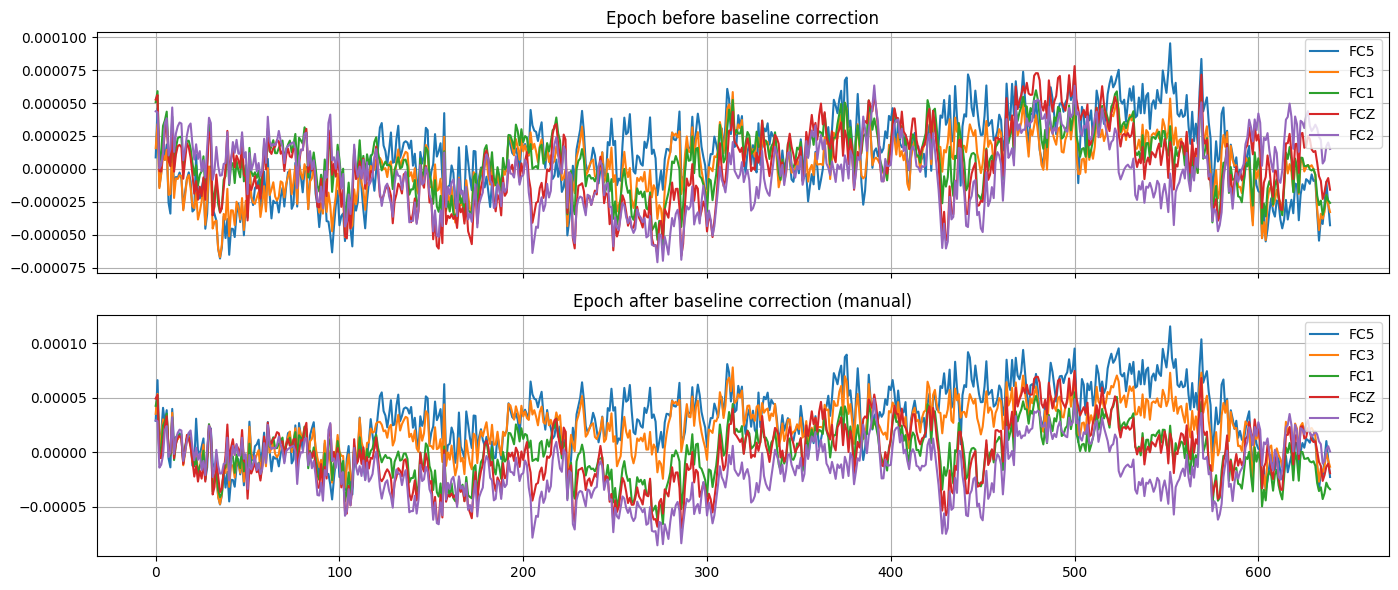


NEXT STEP: Band-pass filter (1-35 Hz) + epoch windowing + PLV computation.


In [38]:
# ---------- STEP 2: Rereferencing and Baseline Correction ----------
import matplotlib.pyplot as plt
import numpy as np

print("\n>>> STEP 2: Rereferencing + Baseline Correction")

# Pick first 5 channels for visualization
plot_channels = raw.ch_names[:5]

# 1) Extract raw data before rereferencing for plotting
data_before_ref, times = raw.get_data(picks=plot_channels, return_times=True)

# 2) Apply common average reference (CAR)
raw.set_eeg_reference(ref_channels='average', verbose=False)
print("Common average reference applied.")

# Extract after rereferencing for plotting
data_after_ref, _ = raw.get_data(picks=plot_channels, return_times=True)

# 3) Visualize before vs after rereferencing
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
for i, ch in enumerate(plot_channels):
    axes[0].plot(times, data_before_ref[i, :], label=ch)
axes[0].set_title("Before Common Average Referencing")
axes[0].set_ylabel("Amplitude (µV)")
axes[0].legend(loc='upper right')
axes[0].grid(True)

for i, ch in enumerate(plot_channels):
    axes[1].plot(times, data_after_ref[i, :], label=ch)
axes[1].set_title("After Common Average Referencing")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude (µV)")
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ---------- Baseline correction ----------
# 4) Define epoch extraction parameters
event_dict = {'T1': 1, 'T2': 2}  # motor imagery events: adjust if needed
tmin, tmax = -0.5, 4.0  # 4s epochs after event onset
baseline_window = (-0.5, 0)  # 0.5s pre-event baseline

# Extract epochs
epochs = mne.Epochs(raw, events=events, event_id=event_dict, tmin=tmin, tmax=tmax,
                    baseline=baseline_window, picks='eeg', preload=True, verbose=False)

print(f"Extracted {len(epochs)} epochs with baseline correction applied.")

# Pick first epoch for visualization
epoch_data_before = epochs.get_data()[0]  # shape: (n_channels, n_times)
# For demonstration, remove baseline manually for comparison
epoch_data_raw = raw.get_data(picks=plot_channels,
                              start=int(events[0,0]),
                              stop=int(events[0,0]+tmax*raw.info['sfreq']))
epoch_baseline = np.mean(epoch_data_raw[:, :int(abs(baseline_window[0])*raw.info['sfreq'])], axis=1, keepdims=True)
epoch_data_manual_corrected = epoch_data_raw - epoch_baseline

# 5) Plot first epoch: before vs after baseline correction
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
for i, ch in enumerate(plot_channels):
    axes[0].plot(epoch_data_raw[i, :], label=ch)
axes[0].set_title("Epoch before baseline correction")
axes[0].legend()
axes[0].grid(True)

for i, ch in enumerate(plot_channels):
    axes[1].plot(epoch_data_manual_corrected[i, :], label=ch)
axes[1].set_title("Epoch after baseline correction (manual)")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()
 



>>> STEP 3: Band-pass filtering + sliding windows + PLV computation
Applied 1-35 Hz band-pass filter to 21 epochs.
Sliding window extraction: 609 windows of shape (64, 160)
Number of electrodes: 64
Number of edges: 331


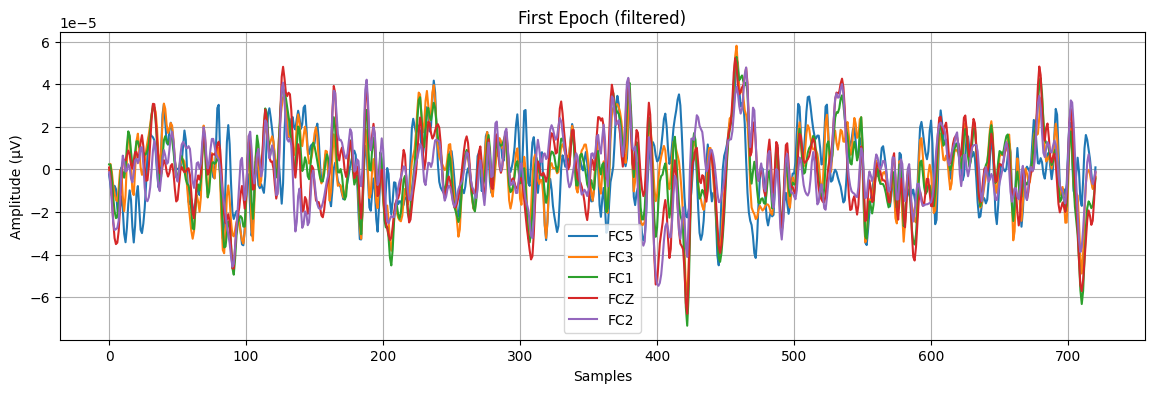

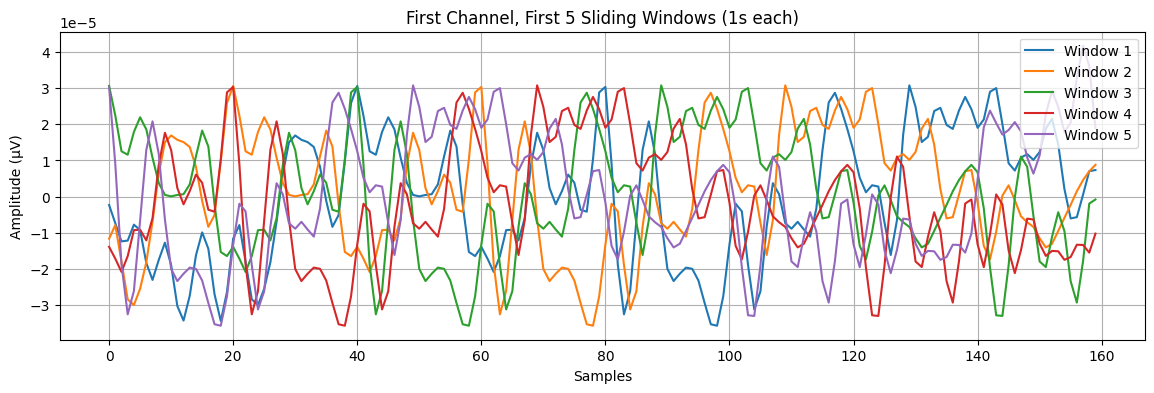

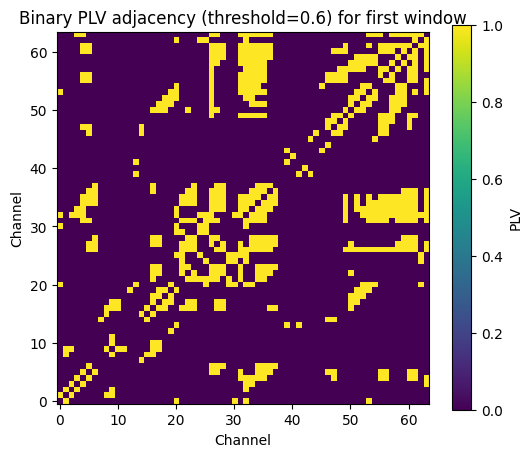

In [40]:
# ---------- STEP 3: Band-pass filtering, sliding windows, PLV ----------
from scipy.signal import butter, filtfilt, hilbert

print("\n>>> STEP 3: Band-pass filtering + sliding windows + PLV computation")

# 1) Band-pass filter function
def bandpass_filter(data, sfreq, low=1.0, high=35.0, order=4):
    nyq = sfreq / 2
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    filtered = filtfilt(b, a, data, axis=1)
    return filtered

# Apply filter to all epochs
sfreq = raw.info['sfreq']
epochs_data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
n_epochs, n_channels, n_times = epochs_data.shape
filtered_epochs = np.zeros_like(epochs_data)

for i in range(n_epochs):
    filtered_epochs[i] = bandpass_filter(epochs_data[i], sfreq)
print(f"Applied 1-35 Hz band-pass filter to {n_epochs} epochs.")

# 2) Sliding window extraction
window_length = int(1.0 * sfreq)  # 1 second
stride = 20                       # 20 samples
windows_per_epoch = (n_times - window_length) // stride + 1

all_windows = []
for ep in filtered_epochs:
    for start in range(0, n_times - window_length + 1, stride):
        end = start + window_length
        win = ep[:, start:end]
        all_windows.append(win)
all_windows = np.array(all_windows)
print(f"Sliding window extraction: {all_windows.shape[0]} windows of shape {all_windows.shape[1:]}")

# 3) PLV computation function
def compute_plv(epoch_data, threshold=0.5):
    """
    epoch_data: np.ndarray (n_channels x n_times)
    returns: adj (binary adjacency), plv_matrix (full)
    """
    n_ch, n_times = epoch_data.shape
    analytic_signal = hilbert(epoch_data, axis=1)
    phases = np.angle(analytic_signal)
    # Compute PLV
    phase_diff = np.expand_dims(phases, axis=0) - np.expand_dims(phases, axis=1)
    plv_matrix = np.abs(np.sum(np.exp(1j * phase_diff), axis=2)) / n_times
    # Threshold to adjacency
    adj = (plv_matrix >= threshold).astype(float)
    np.fill_diagonal(adj, 0)
    return adj, plv_matrix

# Example: compute PLV for first window
example_window = all_windows[0]
adj_matrix, plv_matrix = compute_plv(example_window, threshold=0.6)


n_electrodes = adj_matrix.shape[0]
n_edges = np.sum(np.triu(adj_matrix, k=1))  # count upper-triangle ones

print(f"Number of electrodes: {n_electrodes}")
print(f"Number of edges: {int(n_edges)}")
# 4) Visualizations
import matplotlib.pyplot as plt

# Plot one 4s epoch (first)
plt.figure(figsize=(14, 4))
for i in range(5):  # first 5 channels
    plt.plot(filtered_epochs[0, i], label=raw.ch_names[i])
plt.title("First Epoch (filtered)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid(True)
plt.show()

# Plot sliding windows (first 5 windows, first channel)
plt.figure(figsize=(14, 4))
for i in range(5):
    plt.plot(all_windows[i, 0], label=f"Window {i+1}")
plt.title(f"First Channel, First 5 Sliding Windows (1s each)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid(True)
plt.show()

# Plot PLV adjacency matrix for example window
plt.figure(figsize=(6, 5))
plt.imshow(adj_matrix, cmap='viridis', origin='lower')
plt.title("Binary PLV adjacency (threshold=0.6) for first window")
plt.colorbar(label='PLV')
plt.xlabel("Channel")
plt.ylabel("Channel")
plt.show()



>>> STEP 4: EDA - Class Distribution, Signals, and PLV Overview


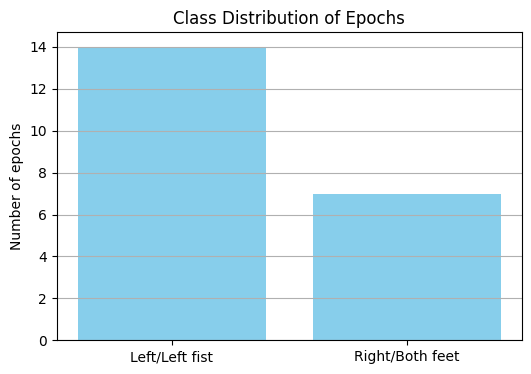

Class counts: {'Left/Left fist': 14, 'Right/Both feet': 7}


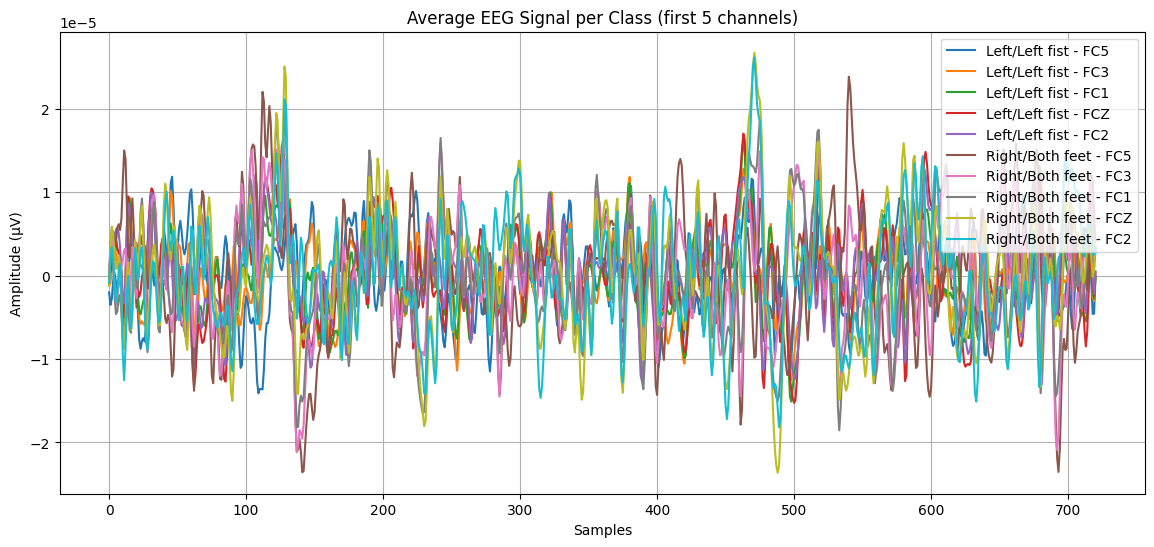

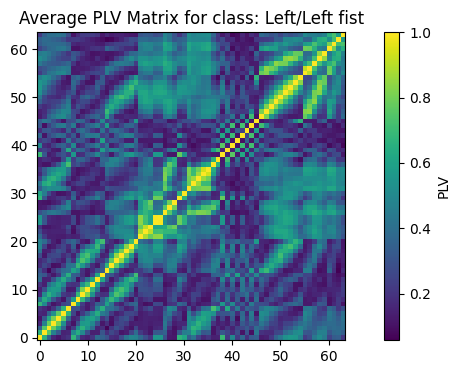

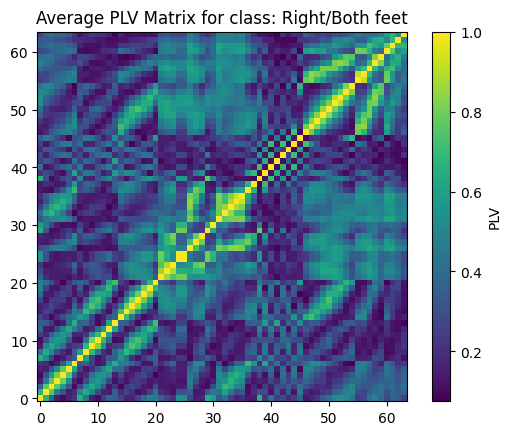

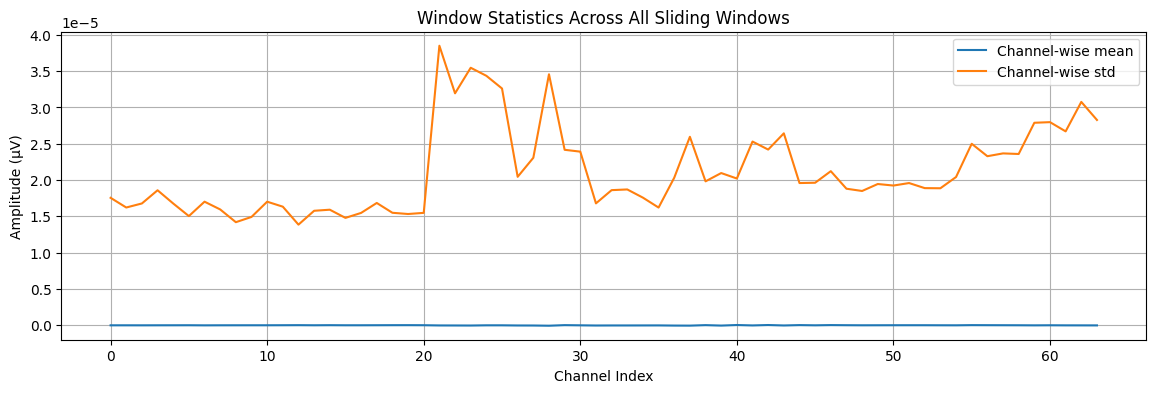

In [41]:
# ---------- STEP 4: Exploratory Data Analysis (EDA) ----------
import matplotlib.pyplot as plt
import numpy as np

print("\n>>> STEP 4: EDA - Class Distribution, Signals, and PLV Overview")

# For demonstration, we will assign class labels from events
# T1 = left, T2 = right motor imagery (adjust if needed)
class_labels_map = {1: 'Left/Right fist', 2: 'Both wrist/Both feet'}  # adapt according to your events

# Map epochs to classes
epoch_classes = []
for ev in events:
    code = ev[2]
    if code in class_labels_map:
        epoch_classes.append(class_labels_map[code])
epoch_classes = np.array(epoch_classes[:n_epochs])  # ensure matches epochs count

# 1) Class distribution
unique_classes, counts = np.unique(epoch_classes, return_counts=True)
plt.figure(figsize=(6,4))
plt.bar(unique_classes, counts, color='skyblue')
plt.title("Class Distribution of Epochs")
plt.ylabel("Number of epochs")
plt.grid(axis='y')
plt.show()
print("Class counts:", dict(zip(unique_classes, counts)))

# 2) Average waveform per class (first 5 channels)
plt.figure(figsize=(14,6))
for i, cls in enumerate(unique_classes):
    idx = np.where(epoch_classes == cls)[0]
    avg_signal = filtered_epochs[idx].mean(axis=0)  # mean across epochs
    for ch in range(5):
        plt.plot(avg_signal[ch], label=f"{cls} - {raw.ch_names[ch]}")
plt.title("Average EEG Signal per Class (first 5 channels)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid(True)
plt.show()

# 3) PLV overview per class (average PLV adjacency)
plt.figure(figsize=(10,4))
for cls in unique_classes:
    idx = np.where(epoch_classes == cls)[0]
    plv_sum = np.zeros((n_channels, n_channels))
    for ep_idx in idx:
        # compute PLV for the whole epoch (4s)
        _, plv = compute_plv(filtered_epochs[ep_idx])
        plv_sum += plv
    plv_avg = plv_sum / len(idx)
    plt.imshow(plv_avg, origin='lower', cmap='viridis')
    plt.title(f"Average PLV Matrix for class: {cls}")
    plt.colorbar(label='PLV')
    plt.show()

# 4) Window statistics (mean/std per channel across all windows)
window_means = all_windows.mean(axis=(0,2))  # mean per channel
window_stds = all_windows.std(axis=(0,2))    # std per channel

plt.figure(figsize=(14,4))
plt.plot(window_means, label='Channel-wise mean')
plt.plot(window_stds, label='Channel-wise std')
plt.title("Window Statistics Across All Sliding Windows")
plt.xlabel("Channel Index")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid(True)
plt.show()


Loaded raw data: <RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>
Cropped to 124s
Montage applied successfully.
Band-pass filter 1-35 Hz applied.


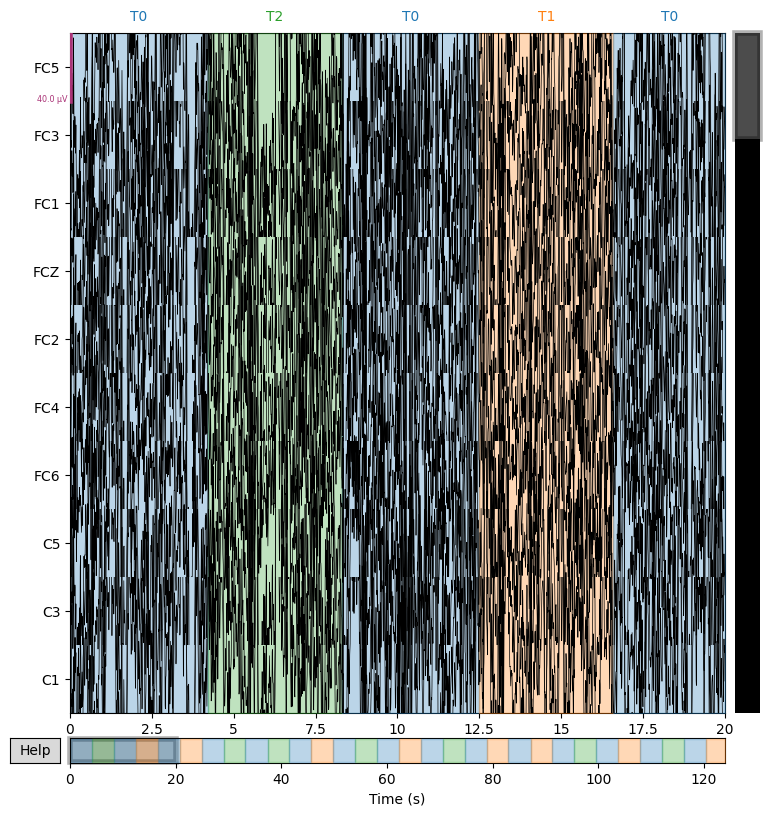

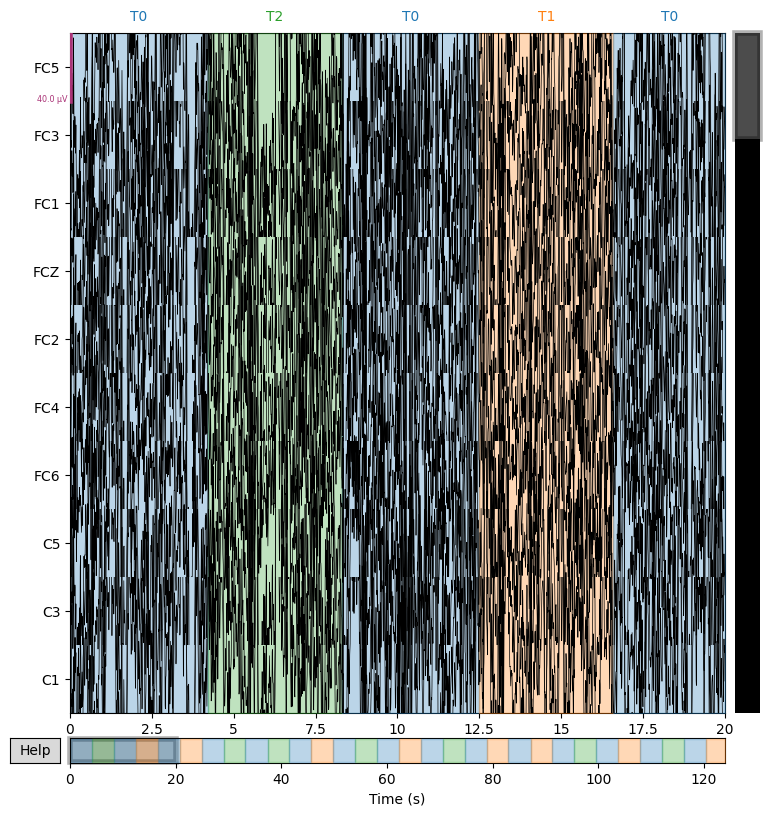

In [58]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import mne

# ---------- Configuration ----------
DATA_DIR = '/kaggle/input/eeg-motor-movementimagery-dataset/files'
SUBJECT_ID = 1
RUN_NUMBER = 4       # motor imagery run
SFREQ = 160          # EEG sampling rate
MAX_CROP_SECS = 124  # crop to match dataset specs
# -----------------------------------

# Find EDF file
edf_file = os.path.join(DATA_DIR, f'S{SUBJECT_ID:03d}', f'S{SUBJECT_ID:03d}R{RUN_NUMBER:02d}.edf')
if not os.path.exists(edf_file):
    raise FileNotFoundError(f"EDF not found: {edf_file}")

# Load raw EEG
raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
print(f"Loaded raw data: {raw}")

# Crop to max duration
if raw.times[-1] > MAX_CROP_SECS:
    raw.crop(tmax=MAX_CROP_SECS)
    print(f"Cropped to {MAX_CROP_SECS}s")

# Fix channel names (BCI2000 names -> standard)
rename_dict = {
    'Fc5.': 'FC5',  'Fc3.': 'FC3',  'Fc1.': 'FC1',  'Fcz.': 'FCZ',  'Fc2.': 'FC2',  'Fc4.': 'FC4',  'Fc6.': 'FC6',
    'C5..': 'C5',   'C3..': 'C3',   'C1..': 'C1',   'Cz..': 'CZ',   'C2..': 'C2',   'C4..': 'C4',   'C6..': 'C6',
    'Cp5.': 'CP5',  'Cp3.': 'CP3',  'Cp1.': 'CP1',  'Cpz.': 'CPZ',  'Cp2.': 'CP2',  'Cp4.': 'CP4',  'Cp6.': 'CP6',
    'Fp1.': 'FP1',  'Fpz.': 'FPZ',  'Fp2.': 'FP2',  'Af7.': 'AF7',  'Af3.': 'AF3',  'Afz.': 'AFZ',  'Af4.': 'AF4',  'Af8.': 'AF8',
    'F7..': 'F7',   'F5..': 'F5',   'F3..': 'F3',   'F1..': 'F1',   'Fz..': 'FZ',   'F2..': 'F2',   'F4..': 'F4',   'F6..': 'F6',   'F8..': 'F8',
    'Ft7.': 'FT7',  'Ft8.': 'FT8',
    'T7..': 'T7',   'T8..': 'T8',   'T9..': 'T9',   'T10.': 'T10',
    'Tp7.': 'TP7',  'Tp8.': 'TP8',
    'P7..': 'P7',   'P5..': 'P5',   'P3..': 'P3',   'P1..': 'P1',   'Pz..': 'PZ',   'P2..': 'P2',   'P4..': 'P4',   'P6..': 'P6',   'P8..': 'P8',
    'Po7.': 'PO7',  'Po3.': 'PO3',  'Poz.': 'POZ',  'Po4.': 'PO4',  'Po8.': 'PO8',
    'O1..': 'O1',   'Oz..': 'OZ',   'O2..': 'O2',   'Iz..': 'IZ'
}
raw.rename_channels(rename_dict)

# Apply standard montage
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage, match_case=False)
print("Montage applied successfully.")

# Apply band-pass filter (1-35 Hz)
raw.filter(l_freq=1.0, h_freq=35.0, fir_design='firwin', verbose=False)
print("Band-pass filter 1-35 Hz applied.")

# Plot first 5 channels, first 5 seconds
raw.plot(n_channels=10, duration=20, title=f'Subject {SUBJECT_ID} Run {RUN_NUMBER}', show=True)


In [59]:
from scipy.signal import hilbert

# --- Define event mapping for motor imagery ---
# This depends on your dataset's annotations (Task 2/4)
# Task 2 (Left/Right fist imagery) -> runs 4,8,12
# Task 4 (Both fists/feet imagery) -> runs 6,10,14
TASK2_RUNS = [4, 8, 12]
TASK4_RUNS = [6, 10, 14]

LABEL_MAPPING = {
    'L': 0,   # Left fist
    'R': 1,   # Right fist
    'LR': 2,  # Both fists
    'F': 3    # Both feet
}

EPOCH_LENGTH = 4.0    # seconds
WINDOW_LENGTH = 1.0   # seconds
WINDOW_STRIDE = 20    # samples

epoch_samples = int(EPOCH_LENGTH * SFREQ)
window_samples = int(WINDOW_LENGTH * SFREQ)
windows_per_epoch = (epoch_samples - window_samples) // WINDOW_STRIDE + 1

print(f"{windows_per_epoch} sliding windows per 4s epoch.")

# --- Extract MNE events from annotations ---
events, event_id = mne.events_from_annotations(raw)

# --- Helper function: compute PLV adjacency ---
def compute_plv_adjacency(epoch_data, threshold=0.6):
    """
    epoch_data: (n_channels, n_times)
    Returns:
        adj: binary adjacency matrix
        plv_matrix: full PLV matrix
    """
    n_ch, n_times = epoch_data.shape
    analytic_signal = hilbert(epoch_data, axis=1)
    phases = np.angle(analytic_signal)
    
    # Phase differences
    phase_diff = np.expand_dims(phases, axis=0) - np.expand_dims(phases, axis=1)
    plv_matrix = np.abs(np.sum(np.exp(1j * phase_diff), axis=2)) / n_times
    
    # Thresholded adjacency
    adj = (plv_matrix >= threshold).astype(float)
    np.fill_diagonal(adj, 0)
    return adj, plv_matrix

# --- Extract epochs and sliding windows ---
all_windows = []
all_labels = []
all_adjs = []

for event in events:
    onset_sample = event[0]
    code = event[2]
    
    # Map numeric event code to label
    if RUN_NUMBER in TASK2_RUNS:
        if code == 2:  label = 'L'
        elif code == 3: label = 'R'
        else: continue
    elif RUN_NUMBER in TASK4_RUNS:
        if code == 2:  label = 'LR'
        elif code == 3: label = 'F'
        else: continue
    else:
        continue
    
    # Extract 4s epoch
    start = onset_sample
    end = start + epoch_samples
    if end > raw.n_times:
        continue
    
    epoch = raw.get_data(start=start, stop=end)
    
    # Ensure 64 channels
    if epoch.shape[0] < 64:
        padding = np.zeros((64 - epoch.shape[0], epoch.shape[1]))
        epoch = np.vstack([epoch, padding])
    elif epoch.shape[0] > 64:
        epoch = epoch[:64, :]
    
    # Compute PLV adjacency for this epoch
    adj, plv_matrix = compute_plv_adjacency(epoch, threshold=0.6)
    
    # Sliding windows
    for start_idx in range(0, epoch.shape[1] - window_samples + 1, WINDOW_STRIDE):
        end_idx = start_idx + window_samples
        window = epoch[:, start_idx:end_idx]
        all_windows.append(window)
        all_labels.append(LABEL_MAPPING[label])
        all_adjs.append(adj.copy())

print(f"Extracted {len(all_windows)} windows from Subject {SUBJECT_ID} Run {RUN_NUMBER}")


25 sliding windows per 4s epoch.
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracted 350 windows from Subject 1 Run 4


In [60]:
# Convert lists to arrays
X = np.array(all_windows)  # shape: (n_windows, n_channels, window_samples)
y = np.array(all_labels)   # shape: (n_windows,)
A = np.array(all_adjs)     # shape: (n_windows, n_channels, n_channels)

print(f"X shape: {X.shape}, y shape: {y.shape}, A shape: {A.shape}")

# Channel-wise z-score normalization per window
for i in range(X.shape[0]):
    for ch in range(X.shape[1]):
        ch_data = X[i, ch, :]
        if np.std(ch_data) > 0:
            X[i, ch, :] = (ch_data - np.mean(ch_data)) / np.std(ch_data)

print("Channel-wise normalization applied.")


X shape: (350, 64, 160), y shape: (350,), A shape: (350, 64, 64)
Channel-wise normalization applied.


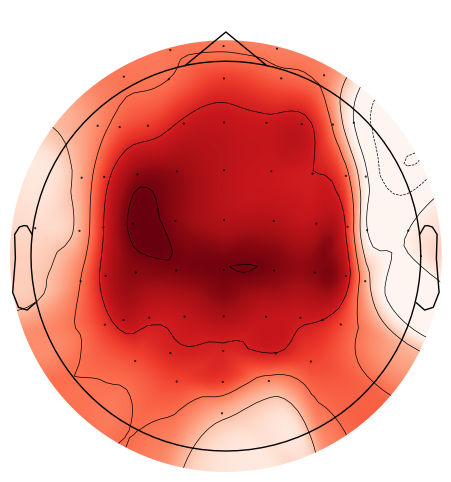

In [92]:
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage
from mne import create_info
from mne.viz import plot_topomap

# --- Create MNE Info object ---
ch_names = raw.ch_names[:64]  # ensure first 64 channels
info = create_info(ch_names=ch_names, sfreq=SFREQ, ch_types='eeg')

# Use standard 10-05 montage
montage = make_standard_montage('standard_1020')
# Set montage (ignore missing channels warning)
info.set_montage(montage, match_case=False, on_missing='ignore')

# --- Compute degree per channel for first window ---
adj_matrix = A[0]  # thresholded PLV adjacency for first window
degree = adj_matrix.sum(axis=0)  # number of connections per channel

# --- Plot topomap ---
fig, ax = plt.subplots(figsize=(6,6))
plot_topomap(degree, info, axes=ax, show=True, cmap='Reds')
ax.set_title("Channel connectivity (PLV degree) - First window")
plt.show()




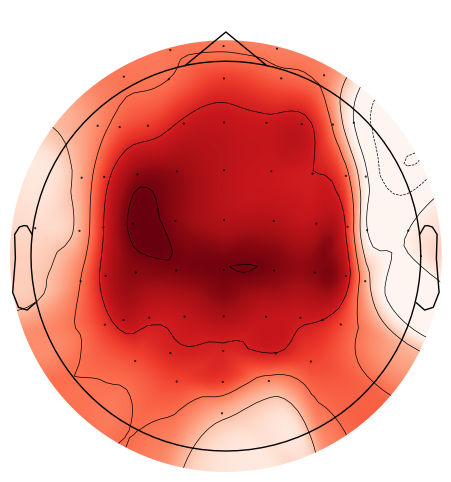

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


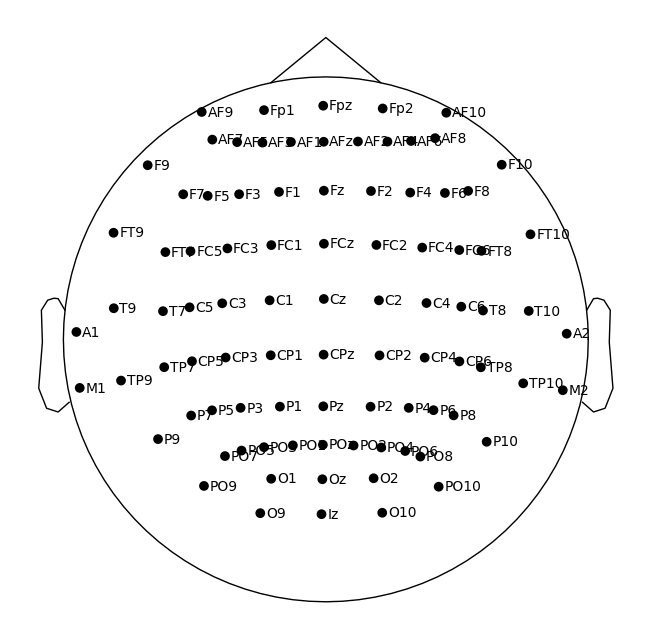

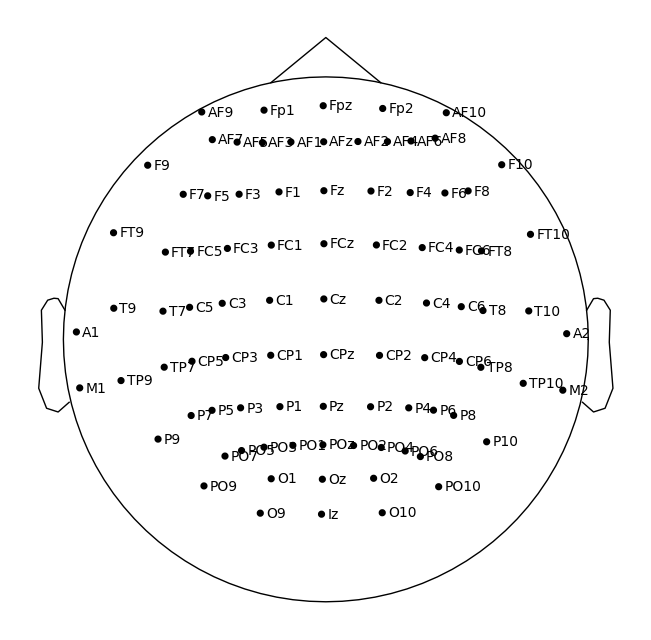

In [93]:
# Degree from first adjacency matrix
adj_matrix = A[0]  # shape: (n_channels, n_channels)
degree = adj_matrix.sum(axis=0)

# Plot topomap
fig, ax = plt.subplots(figsize=(6,6))
mne.viz.plot_topomap(degree, info, axes=ax, show=True, cmap='Reds')
ax.set_title("Channel connectivity (PLV degree) - First window")
plt.show()

mne.viz.plot_montage(montage, show_names=True,sphere=0.115)

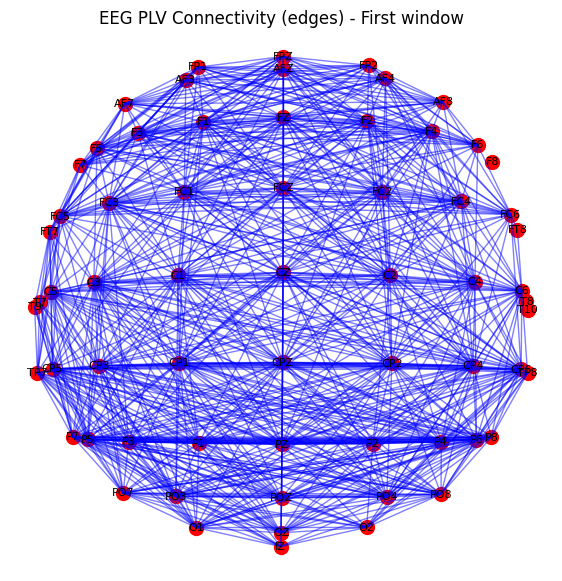

In [75]:
import matplotlib.pyplot as plt

# --- Clean channel names for montage ---

# Create MNE info
info = mne.create_info(ch_names=clean_ch_names, sfreq=data_loader.sampling_rate, ch_types='eeg')
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage, match_case=False, on_missing='ignore')

# --- Get channel 2D positions for plotting ---
pos = np.array([info['chs'][i]['loc'][:2] for i in range(len(info.ch_names))])  # x, y
# Normalize to [-1,1] for plotting
pos = pos / np.max(np.abs(pos))

# --- Adjacency matrix for first window ---
adj_matrix = A[0]  # shape: (n_channels, n_channels)

# --- Plot topomap with edges ---
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(pos[:,0], pos[:,1], s=100, c='r')  # plot nodes

# Draw edges for PLV > threshold
threshold = 0.8
for i in range(adj_matrix.shape[0]):
    for j in range(i+1, adj_matrix.shape[1]):
        if adj_matrix[i,j] >= threshold:
            ax.plot([pos[i,0], pos[j,0]], [pos[i,1], pos[j,1]],
                    c='b', alpha=0.5, lw=1)  # edge

# Annotate nodes
for i, ch_name in enumerate(info.ch_names):
    ax.text(pos[i,0], pos[i,1], ch_name, fontsize=8,
            ha='center', va='center')

ax.set_title("EEG PLV Connectivity (edges) - First window")
ax.axis('off')
plt.show()


In [76]:
window_data = X[0]  # shape: (n_channels=64, n_times=160)

# --- Step 2: Compute PLV ---
def compute_plv(epoch_data):
    n_ch, n_times = epoch_data.shape
    analytic_signal = hilbert(epoch_data, axis=1)
    phases = np.angle(analytic_signal)
    
    phase_diff = np.expand_dims(phases, axis=0) - np.expand_dims(phases, axis=1)
    plv_matrix = np.abs(np.sum(np.exp(1j * phase_diff), axis=2)) / n_times
    np.fill_diagonal(plv_matrix, 0)  # remove self-connections
    return plv_matrix

plv_matrix = compute_plv(window_data)

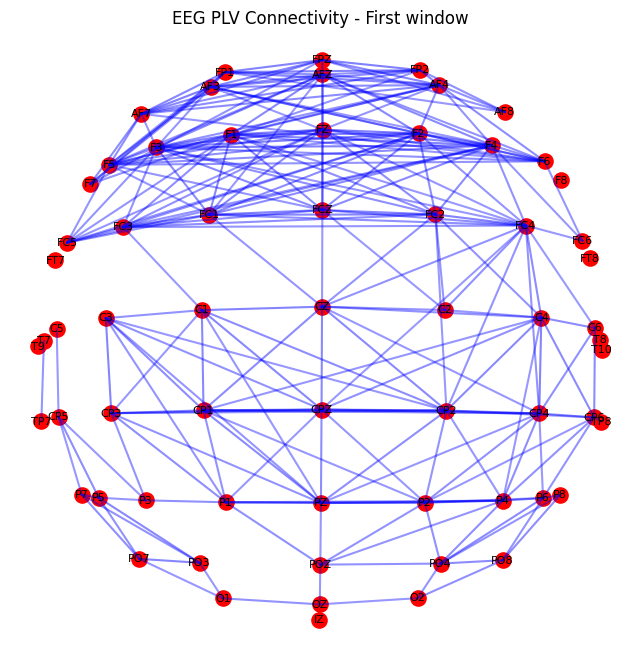

In [78]:
pos = np.array([info['chs'][i]['loc'][:2] for i in range(len(info.ch_names))])
pos = pos / np.max(np.abs(pos))  # normalize to [-1,1]

# --- Step 5: Plot topomap with PLV edges ---
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(pos[:,0], pos[:,1], s=120, c='r')  # plot nodes

# Edge plotting based on PLV threshold
threshold = 0.8
for i in range(plv_matrix.shape[0]):
    for j in range(i+1, plv_matrix.shape[1]):
        if plv_matrix[i,j] >= threshold:
            ax.plot([pos[i,0], pos[j,0]], [pos[i,1], pos[j,1]],
                    c='b', alpha=0.5*plv_matrix[i,j], lw=1.5)  # edge weighted by PLV

# Annotate nodes
for i, ch_name in enumerate(info.ch_names):
    ax.text(pos[i,0], pos[i,1], ch_name, fontsize=8, ha='center', va='center')

ax.set_title("EEG PLV Connectivity - First window")
ax.axis('off')
plt.show()

In [87]:
thresholds = [0.4, 0.6, 0.7,0.75, 0.8,0.85,0.9, 0.95]  # PLV thresholds for visualization
classes = data_loader.class_names  # ['Left Fist', 'Right Fist', ...]
n_channels = X.shape[1]

# Clean channel names for MNE
clean_ch_names = [ch.replace('.', '').upper() for ch in ch_names]


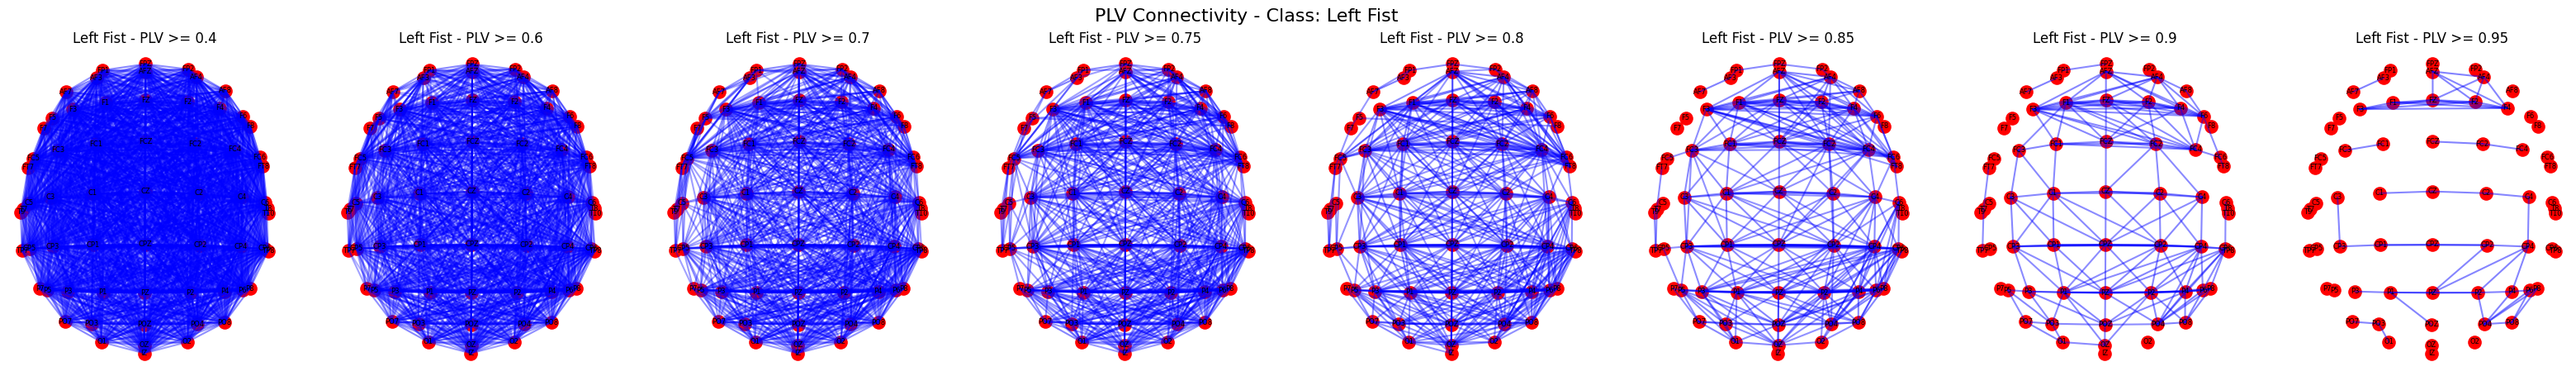

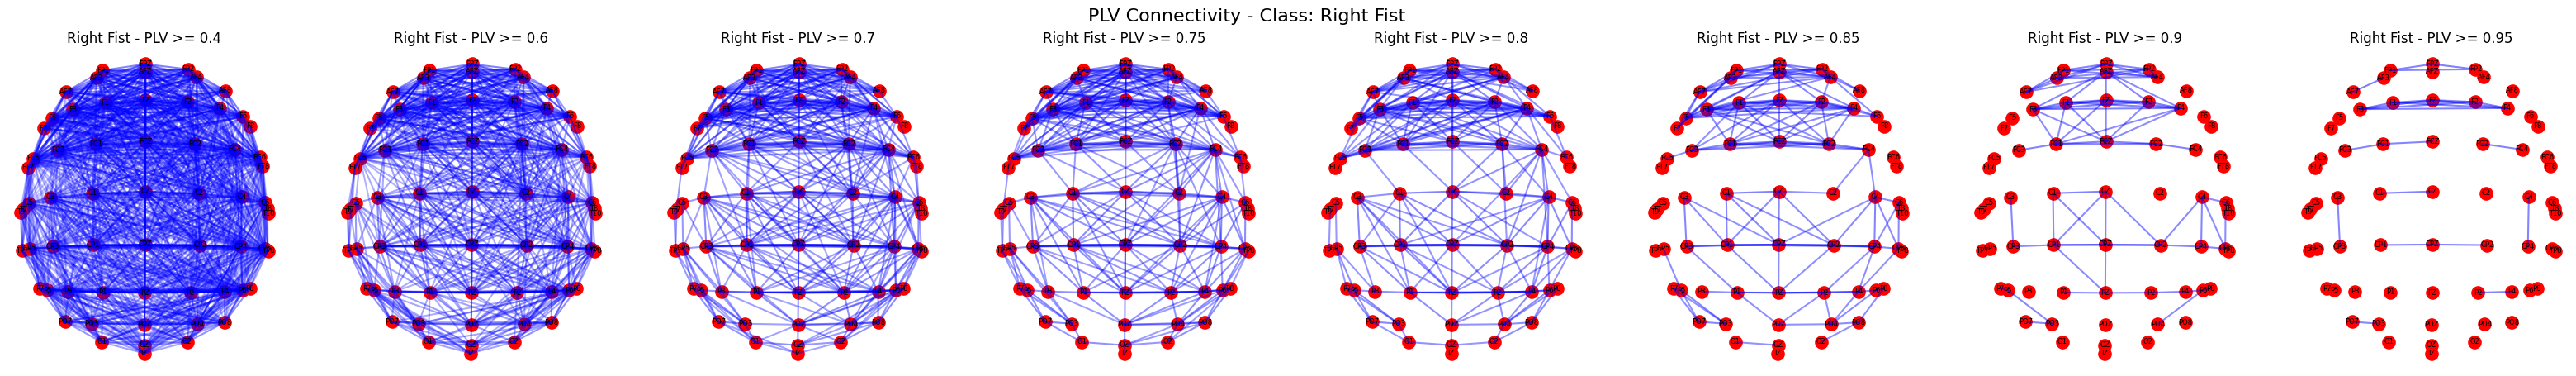

In [88]:
def compute_plv(epoch_data):
    n_ch, n_times = epoch_data.shape
    phases = np.angle(hilbert(epoch_data, axis=1))
    phase_diff = np.expand_dims(phases, axis=0) - np.expand_dims(phases, axis=1)
    plv_matrix = np.abs(np.sum(np.exp(1j * phase_diff), axis=2)) / n_times
    np.fill_diagonal(plv_matrix, 0)
    return plv_matrix

# Helper: get 2D positions
pos = np.array([info['chs'][i]['loc'][:2] for i in range(len(info.ch_names))])
pos = pos / np.max(np.abs(pos))

# --- Plotting ---
for cls_idx, cls_name in enumerate(classes):
    # Get first window of this class
    cls_indices = np.where(y == cls_idx)[0]
    if len(cls_indices) == 0:
        continue
    trial_data = X[cls_indices[0]]  # shape: (64, 160)

    plv_matrix = compute_plv(trial_data)

    fig, axes = plt.subplots(1, len(thresholds), figsize=(5*len(thresholds),5))
    if len(thresholds) == 1:
        axes = [axes]

    for ax, thr in zip(axes, thresholds):
        ax.scatter(pos[:,0], pos[:,1], s=120, c='r')
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if plv_matrix[i,j] >= thr:
                    ax.plot([pos[i,0], pos[j,0]], [pos[i,1], pos[j,1]],
                            c='b', alpha=0.5*plv_matrix[i,j], lw=1.5)
        # Annotate nodes
        for i, ch_name in enumerate(info.ch_names):
            ax.text(pos[i,0], pos[i,1], ch_name, fontsize=6, ha='center', va='center')
        ax.set_title(f"{cls_name} - PLV >= {thr}")
        ax.axis('off')

    plt.suptitle(f"PLV Connectivity - Class: {cls_name}", fontsize=16)
    plt.show()

In [3]:
edf_file = '/kaggle/input/eeg-motor-movementimagery-dataset/files/S001/S001R04.edf'
raw = mne.io.read_raw_edf(edf_file, preload=True)

# Convert events DataFrame to MNE format
events, event_id = mne.events_from_annotations(raw)

events

Extracting EDF parameters from /kaggle/input/eeg-motor-movementimagery-dataset/files/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']


array([[    0,     0,     1],
       [  672,     0,     3],
       [ 1328,     0,     1],
       [ 2000,     0,     2],
       [ 2656,     0,     1],
       [ 3328,     0,     2],
       [ 3984,     0,     1],
       [ 4656,     0,     3],
       [ 5312,     0,     1],
       [ 5984,     0,     3],
       [ 6640,     0,     1],
       [ 7312,     0,     2],
       [ 7968,     0,     1],
       [ 8640,     0,     3],
       [ 9296,     0,     1],
       [ 9968,     0,     2],
       [10624,     0,     1],
       [11296,     0,     3],
       [11952,     0,     1],
       [12624,     0,     2],
       [13280,     0,     1],
       [13952,     0,     2],
       [14608,     0,     1],
       [15280,     0,     3],
       [15936,     0,     1],
       [16608,     0,     2],
       [17264,     0,     1],
       [17936,     0,     3],
       [18592,     0,     1],
       [19264,     0,     2]])

In [53]:
import os
import glob
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Try to import MNE for proper EDF loading, fall back to basic loading if not available
try:
    import mne
    from mne.io import read_raw_edf
    from mne.channels import make_standard_montage
    from mne.datasets import eegbci
    from mne.epochs import Epochs
    MNE_AVAILABLE = True
    print("MNE library available - using proper EDF parsing")
except ImportError:
    MNE_AVAILABLE = False
    print("MNE library not available - using simplified EDF parsing")

# Try to import scipy for filtering if MNE is not available
try:
    from scipy.signal import butter, filtfilt
    SCIPY_AVAILABLE = True
    print("Scipy available for filtering")
except ImportError:
    SCIPY_AVAILABLE = False
    print("Scipy not available - filtering will be skipped")

from scipy.signal import hilbert
class PhysioNetEEGLoader:
    """
    Load PhysioNet EEG Motor Movement/Imagery Dataset following the paper specifications:
    - Windows of 160 samples (1.0s at 160 Hz) with stride = 20 → 25 windows per 4s trial
    - Band-pass filter 1-35 Hz
    - Exclude subjects #88, #89, #92, #100, #104 (resulting in 105 subjects)
    - Only motor imagery classes (no baseline/rest)
    """
    
    def __init__(self, data_dir='/kaggle/input/eeg-motor-movementimagery-dataset/files/', sampling_rate=160):
        self.data_dir = data_dir
        self.sampling_rate = sampling_rate
        
        # Paper specifications for windowing
        self.epoch_length = 4.0  # 4 seconds for full trial
        self.window_length = 1.0  # 1 second sliding windows (160 samples)
        self.window_stride = 20   # 20 samples stride → 25 windows per trial
        
        self.epoch_samples = int(self.epoch_length * sampling_rate)  # 640 samples
        self.window_samples = int(self.window_length * sampling_rate)  # 160 samples
        
        # Calculate number of windows per epoch
        self.windows_per_epoch = (self.epoch_samples - self.window_samples) // self.window_stride + 1
        print(f"Windowing: {self.windows_per_epoch} windows of {self.window_samples} samples per {self.epoch_samples}-sample epoch")
        
        # Motor imagery runs (as per the reference code)
        self.imagery_runs = [4, 6, 8, 10, 12, 14]
        self.task2_runs = [4, 8, 12]  # Left/Right fist
        self.task4_runs = [6, 10, 14]  # Both fists/Both feet
        self.annotations = None
        # Motor imagery only (NO BASELINE) - following paper
        self.label_mapping = {
            'L': 0,   # Left fist imagery
            'R': 1,   # Right fist imagery  
            'LR': 2,  # Both fists imagery
            'F': 3    # Both feet imagery
        }
        
        self.class_names = ['Left Fist', 'Right Fist', 'Both Fists', 'Both Feet']
        
        # Subjects to exclude as per paper: #88, #89, #92, #100, #104
        self.excluded_subjects = [88, 89, 92, 100, 104]
        
        # Use all 64 channels
        self.n_channels = 64
        
        # Filtering parameters 
        self.low_freq = 8.0
        self.high_freq = 32.0
        
        self.bad_epoch_threshold = 150e-6 

    from scipy.signal import hilbert

    def compute_plv_adjacency(self, epoch_data, threshold=0.5):
        """
        Compute PLV adjacency matrix for a 4s epoch
        and threshold it to create a binary adjacency matrix.
    
        Parameters
        ----------
        epoch_data : np.ndarray
            Shape: (n_channels, n_times)
        threshold : float
            PLV threshold to create adjacency
    
        Returns
        -------
        adj : np.ndarray
            Binary adjacency matrix (n_channels x n_channels)
        plv_matrix : np.ndarray
            Full PLV matrix
        """
        n_ch, n_times = epoch_data.shape
        plv_matrix = np.zeros((n_ch, n_ch))
        
        analytic_signal =  hilbert(epoch_data, axis=1)
        phases = np.angle(analytic_signal)
        
        # Inside compute_plv_adjacency, after calculating 'phases'
        phase_diff = np.expand_dims(phases, axis=0) - np.expand_dims(phases, axis=1)
        plv_matrix = np.abs(np.sum(np.exp(1j * phase_diff), axis=2)) / n_times  # symmetry
            
        # Threshold to create adjacency
        adj = (plv_matrix >= threshold).astype(float)
        np.fill_diagonal(adj, 0)  # remove self-loops
        
        return adj, plv_matrix

    def apply_bandpass_filter(self, data):
        """Apply 1-35 Hz band-pass filter as specified in paper"""
        if data is None:
            return None
            
        try:
            if MNE_AVAILABLE and hasattr(data, 'filter'):
                # If data is MNE Raw object, use MNE filtering
                data.filter(l_freq=self.low_freq, h_freq=self.high_freq, 
                           fir_design='firwin', verbose=False)
                return data
            elif SCIPY_AVAILABLE and isinstance(data, np.ndarray):
                # If data is numpy array, use scipy filtering
                nyquist = self.sampling_rate / 2
                low = self.low_freq / nyquist
                high = self.high_freq / nyquist
                
                # Design Butterworth filter
                b, a = butter(4, [low, high], btype='band')
                
                # Apply filter to each channel
                filtered_data = np.zeros_like(data)
                for ch in range(data.shape[0]):
                    filtered_data[ch, :] = filtfilt(b, a, data[ch, :])
                
                return filtered_data
            else:
                print(f"    Warning: No filtering available, returning unfiltered data")
                return data
                
        except Exception as e:
            print(f"    Warning: Filtering failed ({e}), returning unfiltered data")
            return data
    
    def load_raw_edf_with_mne(self, edf_path):
        """Load EDF file using MNE with proper filtering"""
        if not MNE_AVAILABLE:
            return None
            
        try:
            raw = read_raw_edf(edf_path, preload=True, verbose=False)
            
            # Standardize channel names
            eegbci.standardize(raw)
            
            # Set standard montage
            montage = make_standard_montage('standard_1005')
            raw.set_montage(montage, verbose=False)
            
            # Crop to 124 seconds if longer (as per reference code)
            if raw.times[-1] > 124:
                raw.crop(tmax=124)
            
            # Apply band-pass filter (1-35 Hz)
            raw = self.apply_bandpass_filter(raw)
            events, event_id = mne.events_from_annotations(raw)  
            self.annotations = events
            return raw
            
        except Exception as e:
            print(f"    Error loading {os.path.basename(edf_path)} with MNE: {e}")
            return None
    
    
        
    
    
    
    
    def create_sliding_windows(self, epoch_data, epoch_label):
        """
        Create sliding windows from a 4s epoch following paper specifications:
        - Windows of 160 samples (1.0s) with stride = 20 samples
        - Results in 25 windows per 4s trial
        - Each window gets the same label as the parent epoch
        """
        windows = []
        labels = []
        
        if epoch_data.shape[1] < self.window_samples:
            return windows, labels
        
        # Create sliding windows
        for start_idx in range(0, epoch_data.shape[1] - self.window_samples + 1, self.window_stride):
            end_idx = start_idx + self.window_samples
            window = epoch_data[:, start_idx:end_idx]
            
            windows.append(window)
            labels.append(epoch_label)  # Same label for all windows from this epoch
        
        return windows, labels
    
    def extract_epochs_from_signal(self, signal_data, run_number):
        """Extract epochs from signal data using annotations/events"""
        if signal_data is None:
            print("SIGNAL IS NONE")
            return [], []
    
        if self.annotations is None:
            print("No annotations found for this run")
            return [], []
    
        all_windows = []
        all_labels = []
    
        # MNE events are [sample, 0, event_id]
        for event in self.annotations:
            onset_sample = int(event[0])  # sample index of event
            event_code = int(event[2])    # numeric event code
    
            # Map numeric event codes to your labels
            if run_number in self.task2_runs:  # Task 2: Left/Right fist
                if event_code == 2:
                    label = "L"
                elif event_code == 3:
                    label = "R"
                else:
                    continue
            elif run_number in self.task4_runs:  # Task 4: Both fists/feet
                if event_code == 2:
                    label = "LR"
                elif event_code == 3:
                    label = "F"
                else:
                    continue
            else:
                continue
    
            # Extract 4s epoch
            start_sample = onset_sample
            end_sample = start_sample + self.epoch_samples
            if end_sample <= signal_data.shape[1]:
                epoch = signal_data[:, start_sample:end_sample]
                peak_to_peak = epoch.max(axis=1) - epoch.min(axis=1)  # per channel
                if np.any(peak_to_peak > self.bad_epoch_threshold):
                    
                    continue
                # Pad or trim channels to 64
                if epoch.shape[0] < 64:
                    padding = np.zeros((64 - epoch.shape[0], epoch.shape[1]))
                    epoch = np.vstack([epoch, padding])
                elif epoch.shape[0] > 64:
                    epoch = epoch[:64, :]
    
                adj, plv_matrix = self.compute_plv_adjacency(epoch, threshold=0.6)
                windows, labels = self.create_sliding_windows(epoch, self.label_mapping[label])
                adjs = [adj.copy() for _ in range(len(windows))]
    
                all_windows.extend(windows)
                all_labels.extend(labels)
                if not hasattr(self, 'all_adjs'):
                    self.all_adjs = []
                self.all_adjs.extend(adjs)
    
        return all_windows, all_labels

    def load_subject_data(self, subject_id):
        """Load data for a single subject (excluding specified subjects from paper)"""
        # Check if subject should be excluded
        if subject_id in self.excluded_subjects:
            print(f"  Subject S{subject_id:03d}: EXCLUDED (as per paper)")
            return [], []
            
        self.current_subject = subject_id  # Store for annotation loading
        subject_dir = os.path.join(self.data_dir, f'S{subject_id:03d}')
        
        if not os.path.exists(subject_dir):
            print(f"  Subject S{subject_id:03d}: Directory not found")
            return [], []
        
        all_windows = []
        all_labels = []
        total_epochs = 0
        
        for run in self.imagery_runs:
            edf_file = os.path.join(subject_dir, f'S{subject_id:03d}R{run:02d}.edf')
            
            if not os.path.exists(edf_file):
                print(f"    Run {run}: File not found")
                continue
                
            print(f"    Run {run}: Loading...", end=" ")
            
            # Try MNE first, then fall back to simple loading
            signal_data = None
            
        
            raw = self.load_raw_edf_with_mne(edf_file)
            if raw is not None:
                signal_data = raw.get_data()  # Shape: (n_channels, n_samples)
                print(f"(MNE+Filtered: {signal_data.shape})", end=" ")
        
            # Fall back to simple EDF reading
    
            
            # Extract epochs and create sliding windows
            if signal_data is not None:
                windows, labels = self.extract_epochs_from_signal(signal_data, run)
                if len(windows) > 0:
                    all_windows.extend(windows)
                    all_labels.extend(labels)
                    epochs_extracted = len(windows) // self.windows_per_epoch
                    total_epochs += epochs_extracted
                    print(f"✓ {len(windows)} windows ({epochs_extracted} epochs)")
                else:
                    print("✗ No windows extracted")
            else:
                print("✗ No data loaded")
        
        print(f"  Subject S{subject_id:03d}: Total {len(all_windows)} windows from {total_epochs} epochs")
        return all_windows, all_labels
    
    def load_dataset(self, n_subjects=110):
        """
        Load dataset for multiple subjects following paper specifications:
        - Exclude subjects #88, #89, #92, #100, #104
        - Apply 1-35 Hz band-pass filtering
        - Create 160-sample sliding windows with stride=20
        - Only motor imagery classes (no baseline)
        """
        print(f"Loading PhysioNet EEG Motor Imagery Dataset (Paper Implementation)")
        print(f"  Target subjects: {n_subjects} (excluding #88, #89, #92, #100, #104)")
        print(f"  Filtering: {self.low_freq}-{self.high_freq} Hz band-pass")
        print(f"  Windowing: {self.window_samples} samples, stride {self.window_stride} → {self.windows_per_epoch} windows/epoch")
        print(f"  Classes: {self.class_names} (NO baseline)")
        print(f"  Runs: {self.imagery_runs} (motor imagery only)")
        
        all_windows = []
        all_labels = []
        loaded_subjects = 0
        
        # Load subjects S001 to S{n_subjects} (skipping excluded ones)
        for subject_id in range(1, n_subjects + 1):
            if subject_id in self.excluded_subjects:
                continue  # Skip excluded subjects
                
            print(f"\\nProcessing Subject S{subject_id:03d}:")
            windows, labels = self.load_subject_data(subject_id)
            
            if len(windows) > 0:
                all_windows.extend(windows)
                all_labels.extend(labels)
                loaded_subjects += 1
                
                # Show progress every 10 subjects
                if loaded_subjects % 10 == 0:
                    print(f"\\n  Progress: {loaded_subjects} subjects loaded, {len(all_windows)} total windows")
        
        if len(all_windows) == 0:
            print("\\nWarning: No real data found. \..")
            # Generate synthetic data following paper specification
        
        # Convert to numpy arrays
        X = np.array(all_windows)  # Shape: (n_windows, n_channels, window_samples)
        y = np.array(all_labels)
        A = np.array(getattr(data_loader, 'all_adjs', [])) 
        # Channel-wise z-score normalization (per window)
        print(f"\\n  Applying channel-wise normalization...")
        for i in range(X.shape[0]):
            for ch in range(X.shape[1]):
                channel_data = X[i, ch, :]
                if np.std(channel_data) > 0:
                    X[i, ch, :] = (channel_data - np.mean(channel_data)) / np.std(channel_data)
        
       
        print(f"="*60)
        
        return X, y, A

# Load the PhysioNet dataset following paper specifications
print("Initializing PhysioNet EEG data loader (Paper Implementation)...")
data_loader = PhysioNetEEGLoader(data_dir='/kaggle/input/eeg-motor-movementimagery-dataset/files')

# Load dataset (start with fewer subjects for testing)
n_subjects = 1  # Start with 10 subjects, can increase to 110 for full dataset
X, y, A = data_loader.load_dataset(n_subjects=n_subjects)

MNE library available - using proper EDF parsing
Scipy available for filtering
Initializing PhysioNet EEG data loader (Paper Implementation)...
Windowing: 25 windows of 160 samples per 640-sample epoch
Loading PhysioNet EEG Motor Imagery Dataset (Paper Implementation)
  Target subjects: 1 (excluding #88, #89, #92, #100, #104)
  Filtering: 1.0-35.0 Hz band-pass
  Windowing: 160 samples, stride 20 → 25 windows/epoch
  Classes: ['Left Fist', 'Right Fist', 'Both Fists', 'Both Feet'] (NO baseline)
  Runs: [4, 6, 8, 10, 12, 14] (motor imagery only)
\nProcessing Subject S001:
    Run 4: Loading... Used Annotations descriptions: ['T0', 'T1', 'T2']
(MNE+Filtered: (64, 19841)) ✓ 350 windows (14 epochs)
    Run 6: Loading... Used Annotations descriptions: ['T0', 'T1', 'T2']
(MNE+Filtered: (64, 19841)) ✓ 350 windows (14 epochs)
    Run 8: Loading... Used Annotations descriptions: ['T0', 'T1', 'T2']
(MNE+Filtered: (64, 19841)) ✓ 350 windows (14 epochs)
    Run 10: Loading... Used Annotations descri

## 2. Multi-scale Frequency Feature (MFF) Module

The MFF module extracts frequency domain features using temporal convolutional kernels of different scales to capture multi-temporal information.

In [5]:
class ChannelAttention(nn.Module):
    """Channel attention mechanism for multi-scale feature fusion"""
    
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x shape: (batch_size, channels, time)
        avg_out = self.fc(self.avg_pool(x).squeeze(-1))
        max_out = self.fc(self.max_pool(x).squeeze(-1))
        attention = self.sigmoid(avg_out + max_out).unsqueeze(-1)
        return x * attention


class TemporalConvBlock(nn.Module):
    """Temporal convolutional block with residual connection"""
    
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(TemporalConvBlock, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm1d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.2)
        
        # Residual connection
        if in_channels != out_channels:
            self.residual = nn.Conv1d(in_channels, out_channels, 1)
        else:
            self.residual = nn.Identity()
    
    def forward(self, x):
        identity = self.residual(x)
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.dropout(out)
        out = self.bn3(self.conv3(out))
        
        out += identity
        out = self.relu(out)
        
        return out
class MFFModule(nn.Module):
    """
    Multi-scale Feature extraction module that processes each EEG channel INDEPENDENTLY.
    """
    def __init__(self, feature_dim=64):
        super(MFFModule, self).__init__()
        self.feature_dim = feature_dim
        
        # We now process each channel's time-series individually.
        # The input to the conv blocks will be a single channel, so in_channels=1.
        self.temporal_conv1 = TemporalConvBlock(1, feature_dim, kernel_size=3, padding=1)
        self.temporal_conv2 = TemporalConvBlock(1, feature_dim, kernel_size=7, padding=3)
        self.temporal_conv3 = TemporalConvBlock(1, feature_dim, kernel_size=15, padding=7)
        
        self.channel_attention = ChannelAttention(feature_dim * 3)
        self.fusion_conv = nn.Conv1d(feature_dim * 3, feature_dim, kernel_size=1)
        self.fusion_bn = nn.BatchNorm1d(feature_dim)
        
    def forward(self, x):
        # Input shape: (batch_size, n_channels, time_points) -> e.g., (B, 64, 160)
        batch_size, n_channels, time_points = x.shape
        
        # --- THIS IS THE KEY CHANGE ---
        # Reshape to treat each EEG channel as a separate sample in a larger batch.
        # (B, C, T) -> (B * C, 1, T)
        x = x.view(batch_size * n_channels, 1, time_points)
        
        # --- The rest of the logic is the same, but now operates on individual channels ---
        scale1 = self.temporal_conv1(x)
        scale2 = self.temporal_conv2(x)
        scale3 = self.temporal_conv3(x)
        
        multi_scale_features = torch.cat([scale1, scale2, scale3], dim=1)
        attended_features = self.channel_attention(multi_scale_features)
        fused_features = F.relu(self.fusion_bn(self.fusion_conv(attended_features)))
        # Shape of fused_features: (B * C, feature_dim, T)
        
        # Pool over the time dimension to get a single feature vector per channel.
        pooled_features = F.adaptive_avg_pool1d(fused_features, 1).squeeze(-1)
        # Shape of pooled_features: (B * C, feature_dim)
        
        # Reshape back to the desired node feature format for the GAT.
        # (B * C, F) -> (B, C, F)
        node_features = pooled_features.view(batch_size, n_channels, self.feature_dim)
        
        return node_features

# --- Let's run a new test to verify the output shape ---
batch_size, n_channels, time_points = 8, 64, 160
x_test = torch.randn(batch_size, n_channels, time_points)

# Note: The 'in_channels' argument is no longer needed for initialization.
mff = MFFModule(feature_dim=64) 
mff_output = mff(x_test)

print(f"Input shape: {x_test.shape}")
print(f"✅ Corrected MFF output shape: {mff_output.shape}")
print(f"MFF parameters: {sum(p.numel() for p in mff.parameters() if p.requires_grad):,}")
# The output is now (batch_size, n_channels, feature_dim), which is perfect for the GAT.

Input shape: torch.Size([8, 64, 160])
✅ Corrected MFF output shape: torch.Size([8, 64, 64])
MFF parameters: 225,600


In [6]:
import torch

def manual_dense_to_edge_index(adj_matrix: torch.Tensor) -> torch.Tensor:
    """
    Manually converts a single dense adjacency matrix to the edge_index format.
    
    Note: The official PyG function is preferred as it handles batches.
    """
    # Find the indices (row, col) of all non-zero elements
    edge_index = adj_matrix.nonzero().t()
    
    # Ensure the tensor is contiguous in memory for performance
    return edge_index.contiguous()

In [7]:
# First, ensure necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GraphNorm, global_mean_pool
from torch_geometric.utils import dense_to_sparse
# CORRECTED: Import the official utility for converting adjacency matrices

class EndToEnd_MFF_GAT(nn.Module):
    """
    An end-to-end model that combines MFF feature extraction with a GAT classifier.
    """
    def __init__(self, mff_module, hidden_channels=64, heads=4, num_classes=4, n_channels=64):
        super().__init__()
        self.mff = mff_module
        self.n_channels = n_channels
        
        # The input dimension to the GAT is the feature dimension from the MFF module
        gat_in_channels = self.mff.feature_dim

        # GAT stack
        self.conv1 = GATv2Conv(gat_in_channels, hidden_channels, heads=heads)
        self.conv2 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads)
        # Last layer averages the heads' outputs instead of concatenating
        self.conv3 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=1, concat=False)

        # Normalization layers
        self.gn1 = GraphNorm(hidden_channels * heads)
        self.gn2 = GraphNorm(hidden_channels * heads)
        self.gn3 = GraphNorm(hidden_channels)

        # Final classifier
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, x_raw, adj, batch):
        # 1. Reshape raw data for the MFF (CNN) module
        # The PyG loader provides x_raw as (total_nodes, time_points).
        # We need to reshape it to (batch_size, n_channels, time_points).
        batch_size = batch.max().item() + 1
        x_raw_reshaped = x_raw.view(batch_size, self.n_channels, -1)
        
        # 2. Extract node features using the MFF module
        node_feats = self.mff(x_raw_reshaped)
        # The MFF module now correctly outputs (batch_size, n_channels, feature_dim)
        # REMOVED: Unnecessary .permute(0, 2, 1) call
        
        # 3. Reshape node features for the GAT (GNN) module
        # (batch_size, n_channels, feature_dim) -> (total_nodes, feature_dim)
        x = node_feats.view(-1, self.mff.feature_dim)
        
        # 4. Convert the batch of adjacency matrices to PyG's edge_index format
        edge_index, _ = dense_to_sparse(adj)

        # 5. Apply the Graph Attention Network layers
        x = F.elu(self.conv1(x, edge_index))
        x = self.gn1(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = self.gn2(x, batch)
        x = self.conv3(x, edge_index)
        x = self.gn3(x, batch)
        
        # 6. Readout, Pooling, and Final Classification
        graphemb = global_mean_pool(x, batch) # Pool all nodes in a graph to get one vector
        x = F.dropout(graphemb, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x, graphemb

# --- Sanity Check ---
# Let's simulate a batch of data from the PyG DataLoader to test the model
print("Running model sanity check...")
sim_batch_size = 8
sim_n_channels = 64
sim_time_points = 160
sim_feature_dim = 30

# Instantiate the MFF module
mff_test = MFFModule(feature_dim=sim_feature_dim)

# Instantiate the full model
model_test = EndToEnd_MFF_GAT(mff_test, n_channels=sim_n_channels)

# Create dummy data with the shapes the PyG DataLoader would provide
sim_x_raw = torch.randn(sim_batch_size * sim_n_channels, sim_time_points)
sim_adj = torch.randint(0, 2, (sim_batch_size, sim_n_channels, sim_n_channels)).float()
sim_batch_vec = torch.arange(sim_batch_size).repeat_interleave(sim_n_channels)

# Perform a forward pass
try:
    output,emb = model_test(sim_x_raw, sim_adj, sim_batch_vec)
    print(f"✅ Sanity check passed!")
    print(f"Input x_raw shape (from loader): {sim_x_raw.shape}")
    print(f"Input adj shape (from loader): {sim_adj.shape}")
    print(f"Final output shape: {output.shape}") 
    
    print(f"MFF parameters: {sum(p.numel() for p in model_test.parameters() if p.requires_grad):,}")# Should be (batch_size, num_classes)
except Exception as e:
    print(f"❌ Sanity check failed: {e}")

Running model sanity check...
✅ Sanity check passed!
Input x_raw shape (from loader): torch.Size([512, 160])
Input adj shape (from loader): torch.Size([8, 64, 64])
Final output shape: torch.Size([8, 4])
MFF parameters: 233,922


In [8]:
import numpy as np

class EarlyStopping:
    """Stops training early if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after the last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
            trace_func (function): Function to use for printing messages.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [19]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np

# ===================================================================
# 1. DATA PREPARATION
# ===================================================================

# --- Load the raw data using the verified loader ---
print("Initializing PhysioNet EEG data loader...")
data_loader = PhysioNetEEGLoader(data_dir='/kaggle/input/eeg-motor-movementimagery-dataset/files/')

# NOTE: Start with a small number of subjects for faster testing.
# You can increase this to 105 for the full dataset.
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np

DATASET_ROOT_PATH = '/kaggle/input/stroke-dataset-liu/edffile/edffile'
print("Initializing PhysioNet EEG data loader...")

# 2. Create an instance of the data loader
data_loader = AcuteStrokeMIDataloader(data_dir=DATASET_ROOT_PATH)
print("Loading dataset for 2 subjects...")

# 3. Specify which subjects you want to load
subjects_to_load = 1

# 4. Run the loader
X_data, y_data, A_data = data_loader.load_dataset(n_subjects=subjects_to_load)

if X_data.size > 0:
    
    # =========================================================================
    # --- DATA SPLITTING (EPOCH-AWARE) ---
    # =========================================================================
    import torch
    from sklearn.model_selection import train_test_split
    from torch_geometric.data import Data
    from torch_geometric.loader import DataLoader

    # 1. Determine the number of epochs and their corresponding labels
    windows_per_epoch = data_loader.windows_per_epoch
    n_windows = X_data.shape[0]
    n_epochs = n_windows // windows_per_epoch
    
    # Get the label for each epoch (since all windows in an epoch have the same label)
    epoch_labels = y_data[::windows_per_epoch]
    epoch_indices = np.arange(n_epochs)

    # 2. Split the *epoch indices* while stratifying by epoch labels
    train_epoch_indices, val_epoch_indices = train_test_split(
        epoch_indices,
        test_size=0.2,
        random_state=42,
        stratify=epoch_labels
    )
    

    # 3. Reconstruct the list of *window indices* for train and validation sets
    train_window_indices = []
    for idx in train_epoch_indices:
        start = idx * windows_per_epoch
        end = start + windows_per_epoch
        train_window_indices.extend(range(start, end))

    val_window_indices = []
    for idx in val_epoch_indices:
        start = idx * windows_per_epoch
        end = start + windows_per_epoch
        val_window_indices.extend(range(start, end))
        
    # 4. Create PyG Data objects for the entire dataset
    print("\nConverting numpy arrays to PyG Data objects...")

    X_tensor = torch.tensor(X_data, dtype=torch.float32)
    y_tensor = torch.tensor(y_data, dtype=torch.long)
    A_tensor = torch.tensor(A_data, dtype=torch.float32)
    
    data_list = [Data(x_raw=X_tensor[i], adj=A_tensor[i], y=y_tensor[i]) for i in range(n_windows)]
    print(f"Created {len(data_list)} total graph objects (windows).")

    # 5. Create the final train and validation lists using the calculated indices
    train_data = [data_list[i] for i in train_window_indices]
    val_data = [data_list[i] for i in val_window_indices]
    print("Splitting data into training and validation sets...")

    # 6. Create the DataLoaders
    batch_size = 32
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    print(f"\nTraining samples (windows): {len(train_data)} | Validation samples (windows): {len(val_data)}")
    print("Data pipeline is ready!")

else:
    print("\nCould not load data. Please check the `DATASET_ROOT_PATH` variable.")





Initializing PhysioNet EEG data loader...
Windowing: 25 windows of 160 samples per 640-sample epoch
Loading dataset for 2 subjects...
Loading PhysioNet EEG Motor Imagery Dataset (Paper Implementation)
  Target subjects: 1 (excluding #88, #89, #92, #100, #104)
  Filtering: 1.0-35.0 Hz band-pass
  Windowing: 160 samples, stride 20 → 25 windows/epoch
  Classes: ['Left Fist', 'Right Fist', 'Both Fists', 'Both Feet'] (NO baseline)
  Runs: [4, 6, 8, 10, 12, 14] (motor imagery only)
\nProcessing Subject S001:
    Run 4: Loading... Used Annotations descriptions: ['T0', 'T1', 'T2']
(MNE+Filtered: (64, 19841)) ✓ 350 windows (14 epochs)
    Run 6: Loading... Used Annotations descriptions: ['T0', 'T1', 'T2']
(MNE+Filtered: (64, 19841)) ✓ 350 windows (14 epochs)
    Run 8: Loading... Used Annotations descriptions: ['T0', 'T1', 'T2']
(MNE+Filtered: (64, 19841)) ✓ 350 windows (14 epochs)
    Run 10: Loading... Used Annotations descriptions: ['T0', 'T1', 'T2']
(MNE+Filtered: (64, 19841)) ✓ 350 windows

In [22]:

# ===================================================================
# 2. MODEL TRAINING AND EVALUATION
# ===================================================================

# --- Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# --- Initialize the verified models ---
# The MFFModule is initialized first
mff_module = MFFModule(feature_dim=32).to(device)
# Then the main model is initialized with the MFF module
model = EndToEnd_MFF_GAT(mff_module, hidden_channels=32, heads=4, num_classes=4, n_channels=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
patience = 20  # Number of epochs to wait for improvement before stopping

# Initialize EarlyStopping object
early_stopping = EarlyStopping(patience=patience, verbose=True, path='best_model.pt')

print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")

# --- Training function ---
import matplotlib.pyplot as plt
from collections import deque
import numpy as np

# --- (1) Updated training function: returns avg_loss and train_acc ---
def train(loader):
    model.train()
    total_loss = 0.0
    correct = 0
    for data in loader:  # DataBatch
        data = data.to(device)
        optimizer.zero_grad()

        out,_ = model(data.x_raw, data.adj, data.batch)         # same forward
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())

    avg_loss = total_loss / len(loader.dataset)
    train_acc = correct / len(loader.dataset)
    return avg_loss, train_acc

# --- (2) test() is already returning (acc, avg_loss) so keep as-is ---
@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    total_loss = 0.0
    for data in loader:
        data = data.to(device)
        out,_ = model(data.x_raw, data.adj, data.batch)
        loss = criterion(out, data.y)
        pred = out.argmax(dim=1)

        correct += int((pred == data.y).sum())
        total_loss += loss.item() * data.num_graphs

    acc = correct / len(loader.dataset)
    avg_loss = total_loss / len(loader.dataset)
    return acc, avg_loss

# --- (3) Main training loop with history recording ---
epochs = 2500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("\nStarting training...")
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(train_loader)
    val_acc, val_loss = test(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    scheduler.step()

    print(f'Epoch: {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
          f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("\nTraining finished!")



Using device: cuda
Model initialized with 108,676 trainable parameters.

Starting training...
Epoch: 01 | Train Loss: 1.3889 | Val Loss: 1.3888 | Train Acc: 0.2500 | Val Acc: 0.2500
Validation loss decreased (inf --> 1.388807).  Saving model ...
Epoch: 02 | Train Loss: 1.3888 | Val Loss: 1.3887 | Train Acc: 0.2500 | Val Acc: 0.2500
Validation loss decreased (1.388807 --> 1.388667).  Saving model ...
Epoch: 03 | Train Loss: 1.3887 | Val Loss: 1.3885 | Train Acc: 0.2500 | Val Acc: 0.2500
Validation loss decreased (1.388667 --> 1.388500).  Saving model ...
Epoch: 04 | Train Loss: 1.3885 | Val Loss: 1.3883 | Train Acc: 0.2500 | Val Acc: 0.2500
Validation loss decreased (1.388500 --> 1.388342).  Saving model ...
Epoch: 05 | Train Loss: 1.3884 | Val Loss: 1.3883 | Train Acc: 0.2500 | Val Acc: 0.2500
Validation loss decreased (1.388342 --> 1.388258).  Saving model ...
Epoch: 06 | Train Loss: 1.3882 | Val Loss: 1.3881 | Train Acc: 0.2500 | Val Acc: 0.2500
Validation loss decreased (1.388258 -

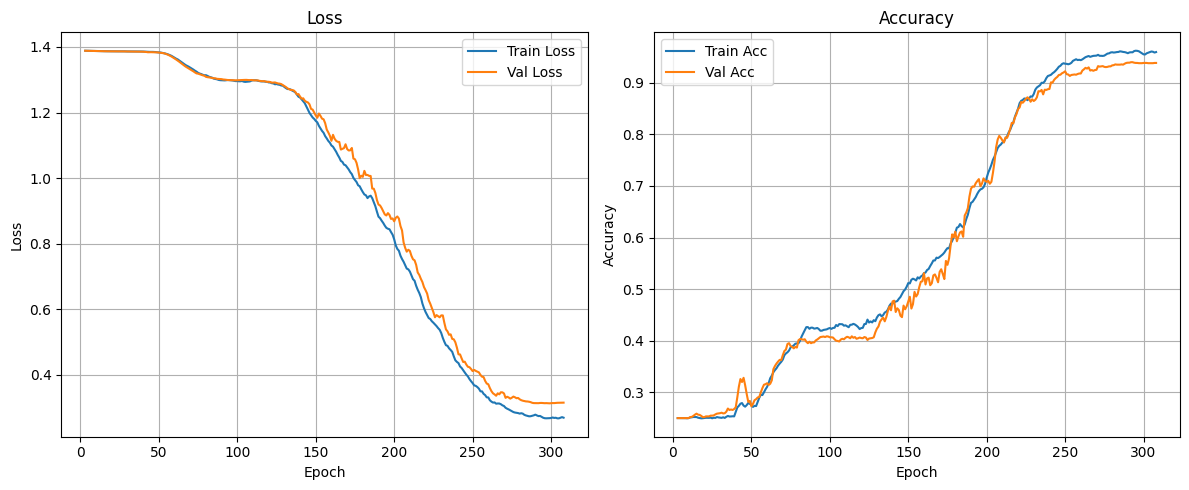

<Figure size 640x480 with 0 Axes>

In [35]:
# --- plotting helper: optional smoothing (moving average) ---
def smooth(y, window=1):
    if window <= 1:
        return np.array(y)
    kernel = np.ones(window) / window
    return np.convolve(y, kernel, mode='valid')

# Choose smoothing window (set to 1 for no smoothing, e.g. 5 for light smoothing)
smooth_window = 5

epochs_range = np.arange(1, len(train_losses) + 1)

if smooth_window > 1:
    pad = smooth_window // 2
    epochs_range = epochs_range[pad: -pad]

plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, smooth(train_losses, smooth_window), label='Train Loss')
plt.plot(epochs_range, smooth(val_losses, smooth_window), label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, smooth(train_accs, smooth_window), label='Train Acc')
plt.plot(epochs_range, smooth(val_accs, smooth_window), label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the figure if you want:
plt.savefig("training_curves.png", bbox_inches='tight', dpi=150)


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

def plot_tsne(embeddings, labels, class_names):
    """Generates and displays a t-SNE plot of the embeddings."""
    print("Running t-SNE... (this may take a moment)")
    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)
    
    # Create a DataFrame for easier plotting with seaborn
    df = pd.DataFrame({
        'tsne-1': tsne_results[:,0],
        'tsne-2': tsne_results[:,1],
        'label': [class_names[l] for l in labels]
    })
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="tsne-1", y="tsne-2",
        hue="label",
        palette=sns.color_palette("hls", len(class_names)),
        data=df,
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE Visualization of Graph Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Motor Imagery Class')
    plt.show()

Running t-SNE... (this may take a moment)


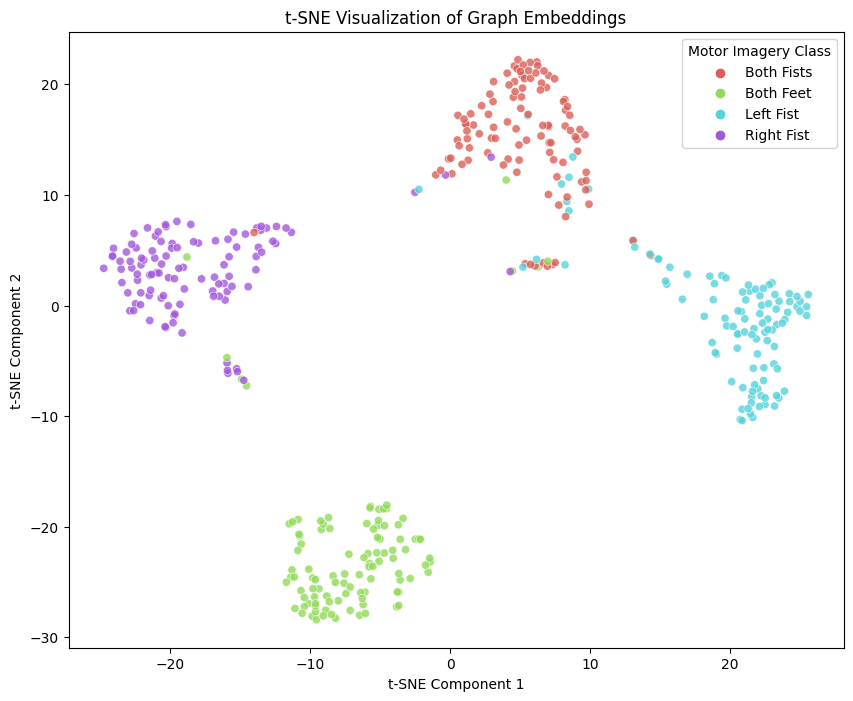

In [31]:
# --- AFTER your training loop finishes ---

# Load the best model weights
model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))
model.eval()

# Collect all embeddings and labels from the validation set
all_embeddings = []
all_labels = []

with torch.no_grad():
    for data in val_loader:
        data = data.to(device)
        # The model now returns two items
        predictions, embeddings = model(data.x_raw, data.adj, data.batch)
        all_embeddings.append(embeddings.cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

# Concatenate all batches
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Generate the plot
plot_tsne(all_embeddings, all_labels, data_loader.class_names)